# **Entrenamiento de YOLOv8n (Detección de personas)**

# 1: Configuración del entorno

Propósito: Preparar Colab, instalar dependencias y verificar GPU.

In [ ]:
# Configuración del entorno
# - Instalar dependencias, montar Drive, preparar entorno gráfico
# - Verificar GPU para entrenamiento

from google.colab import drive
import os
import torch
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime


In [ ]:
# Montar Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Instalar Ultralytics y dependencias gráficas
!pip install ultralytics matplotlib

In [ ]:
# Importar YOLO
from ultralytics import YOLO

In [ ]:
# Verificar GPU
print("GPU disponible:", torch.cuda.is_available())
print("Dispositivo:", torch.cuda.current_device(), torch.cuda.get_device_name(0))

# Definir rutas
BASE_PATH = "/content/drive/MyDrive/Proyecto IA-3/violence_school_project/"
DATA_PATH = os.path.join(BASE_PATH, "yolo_data")
MODEL_PATH = os.path.join(BASE_PATH, "models/yolo_V2")
os.makedirs(MODEL_PATH, exist_ok=True)

# Directorio para gráficos y checkpoints
RUN_ID = datetime.now().strftime("%Y%m%d_%H%M%S")
RUN_PATH = os.path.join(MODEL_PATH, f"run_{RUN_ID}")
os.makedirs(RUN_PATH, exist_ok=True)

print("Rutas configuradas:", DATA_PATH, RUN_PATH)

GPU disponible: True
Dispositivo: 0 Tesla T4
Rutas configuradas: /content/drive/MyDrive/Proyecto IA-3/violence_school_project/yolo_data /content/drive/MyDrive/Proyecto IA-3/violence_school_project/models/yolo_V2/run_20250406_203802


In [ ]:
# Crear data.yaml en Colab
import os

BASE_PATH = "/content/drive/MyDrive/Proyecto IA-3/violence_school_project/"
DATA_PATH = os.path.join(BASE_PATH, "yolo_data")

yaml_content = """
train: ./images/train
val: ./images/val
test: ./images/test
nc: 1
names:
  - persona
"""

with open(os.path.join(DATA_PATH, "data.yaml"), "w") as f:
    f.write(yaml_content)

print("data.yaml creado en:", os.path.join(DATA_PATH, "data.yaml"))

data.yaml creado en: /content/drive/MyDrive/Proyecto IA-3/violence_school_project/yolo_data/data.yaml


# 2: Verificación del dataset

Validar estructura y contenido del dataset.

In [ ]:
# Verificación del dataset
# - Comprobar estructura y archivos para evitar errores
# - Mostrar información básica

def verify_dataset(data_path):
    expected_dirs = ["images/train", "images/val", "images/test", "labels/train", "labels/val", "labels/test"]
    for subdir in expected_dirs:
        full_path = os.path.join(data_path, subdir)
        assert os.path.exists(full_path), f"Directorio faltante: {full_path}"
        files = os.listdir(full_path)
        assert len(files) > 0, f"Directorio vacío: {full_path}"
        print(f"{subdir}: {len(files)} archivos")

    yaml_path = os.path.join(data_path, "data.yaml")
    assert os.path.exists(yaml_path), "data.yaml no encontrado"
    with open(yaml_path, 'r') as f:
        print("Contenido de data.yaml:\n", f.read())

verify_dataset(DATA_PATH)

images/train: 3500 archivos
images/val: 1000 archivos
images/test: 500 archivos
labels/train: 3500 archivos
labels/val: 1000 archivos
labels/test: 500 archivos
Contenido de data.yaml:
 
train: ./images/train
val: ./images/val
test: ./images/test
nc: 1
names:
  - persona



## 2.5: Visualización de imágenes con bounding boxes

In [ ]:
# Visualización de imágenes con bounding boxes
# - Cargar imágenes y etiquetas del dataset
# - Dibujar bounding boxes y mostrarlas para inspección visual

import os
import cv2
import matplotlib.pyplot as plt
import random

# Definir rutas
DATA_PATH = "/content/drive/My Drive/Proyecto IA-3/violence_school_project/yolo_data"
IMG_DIR = os.path.join(DATA_PATH, "images/train")  # Cambia a "val" o "test" si prefieres
LABEL_DIR = os.path.join(DATA_PATH, "labels/train")

# Función para dibujar bounding boxes
def draw_bounding_boxes(img_path, label_path):
    # Leer imagen
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convertir a RGB para Matplotlib
    h, w, _ = img.shape

    # Leer etiquetas
    with open(label_path, 'r') as f:
        labels = f.readlines()

    for label in labels:
        class_id, x_center, y_center, width, height = map(float, label.strip().split())
        # Convertir de formato YOLO normalizado a píxeles
        x_center *= w
        y_center *= h
        width *= w
        height *= h
        # Calcular esquinas del bounding box
        x_min = int(x_center - width / 2)
        y_min = int(y_center - height / 2)
        x_max = int(x_center + width / 2)
        y_max = int(y_center + height / 2)
        # Dibujar rectángulo
        cv2.rectangle(img, (x_min, y_min), (x_max, y_max), (255, 0, 0), 2)
        # Añadir etiqueta
        cv2.putText(img, "persona", (x_min, y_min - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)

    return img

# Seleccionar imágenes aleatorias
img_files = os.listdir(IMG_DIR)
random.shuffle(img_files)
sample_files = img_files[:10] # 10 imagenes

# Mostrar imágenes
plt.figure(figsize=(25, 20))
for i, img_file in enumerate(sample_files):
    img_path = os.path.join(IMG_DIR, img_file)
    label_file = img_file.replace(".jpg", ".txt")  # Asume que las etiquetas tienen el mismo nombre
    label_path = os.path.join(LABEL_DIR, label_file)

    if os.path.exists(label_path):
        img_with_boxes = draw_bounding_boxes(img_path, label_path)
        plt.subplot(5, 2, i + 1)
        plt.imshow(img_with_boxes)
        plt.title(f"Imagen: {img_file}")
        plt.axis("off")
    else:
        print(f"Etiqueta no encontrada para {img_file}")

plt.tight_layout()
plt.show()

# Guardar una muestra para referencia
sample_img = draw_bounding_boxes(
    os.path.join(IMG_DIR, sample_files[0]),
    os.path.join(LABEL_DIR, sample_files[0].replace(".jpg", ".txt"))
)
cv2.imwrite(os.path.join(DATA_PATH, "sample_with_boxes.jpg"), cv2.cvtColor(sample_img, cv2.COLOR_RGB2BGR))
print("Muestra guardada en:", os.path.join(DATA_PATH, "sample_with_boxes.jpg"))

Output hidden; open in https://colab.research.google.com to view.

# 3: ENTRENAMIENTO CON Transfer Learning

Entrenar el head con pesos preentrenados, guardando métricas y checkpoints.

In [ ]:

# - Entrenar YOLOv8n con transfer learning, mostrando avance por época
# - Usar tqdm para barra de progreso

# Instalar tqdm si no está instalado
!pip install tqdm

from ultralytics import YOLO
import os
from tqdm import tqdm  # Para barra de progreso

# Cargar el modelo YOLOv8n preentrenado en COCO
model = YOLO("yolov8n.pt")
model.model.nc = 1 # Ajustar el número de clases a 1 ("persona")

# Definir los nombres de las clases
# - Asignamos "persona" como la única clase (índice 0)
model.model.names = ["persona"]

# Congelar backbone
# - Congelamos 10 capas para preservar esos conocimientos preentrenados durante transfer learning
# - Solo entrenaremos el "head" (capas finales) inicialmente
freeze_layers = 10
for param in list(model.model.parameters())[:freeze_layers]:
    param.requires_grad = False # Desactiva el cálculo de gradientes para estas capas
print(f"Congeladas primeras {freeze_layers} capas")

# Listas para métricas
train_losses = []  # Pérdida en entrenamiento
val_losses = []    # Pérdida en validación
train_maps = []    # mAP@0.5 en entrenamiento
val_maps = []      # mAP@0.5 en validación



# Callback para métricas y checkpoints
def on_epoch_end(trainer):
    # Extraer métricas del diccionario epoch_results del trainer
    # - "train/loss" y "val/loss" son las pérdidas promedio por época
    # - "metrics/mAP50(B)" es el mAP@0.5 (IoU 0.5, métrica clave)
    train_loss = trainer.epoch_results["train/loss"]
    val_loss = trainer.epoch_results["val/loss"]
    train_map = trainer.epoch_results["metrics/mAP50(B)"]
    val_map = trainer.epoch_results["metrics/mAP50(B)"]

    # Añadir métricas a las listas
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_maps.append(train_map)
    val_maps.append(val_map)

    # Guardar un checkpoint cada 10 épocas
    if trainer.epoch % 10 == 0:
        checkpoint_path = os.path.join(RUN_PATH, f"transfer_epoch_{trainer.epoch}.pt")
        trainer.model.save(checkpoint_path)
        print(f"Checkpoint guardado: {checkpoint_path}")



# Callback para actualizar barra de progreso
def on_epoch_begin(trainer):
    trainer.progress_bar.set_description(f"Época {trainer.epoch + 1}/{trainer.epochs}")

model.add_callback("on_epoch_begin", on_epoch_begin)
model.add_callback("on_epoch_end", on_epoch_end)



# Configurar entrenamiento con barra de progreso
epochs = 50 # Número de epoch

with tqdm(total=epochs, desc="Entrenamiento", unit="época") as progress_bar:
    # Definir función auxiliar para actualizar barra
    def update_progress(trainer):
        progress_bar.update(1)

    # Añadir callback para actualizar barra al final de cada época
    model.add_callback("on_epoch_end", update_progress)

    # Entrenar
    transfer_results = model.train(
        data=os.path.join(DATA_PATH, "data.yaml"),
        epochs=epochs,    # 50 épocas para un entrenamiento inicial robusto
        imgsz=640,        #  Tamaño de imagen 640x640 (estándar para YOLOv8)
        batch=16,         # Lote de 16 imágenes por iteración (ajustado para GPU T4)
        lr0=0.01,         # Tasa de aprendizaje inicial de 0.01 (alta para transfer learning)
        momentum=0.9,     # 0.9 para SGD, ayuda a estabilizar la optimización
        weight_decay=0.0, # 0.0 (sin regularización por ahora, ajustable después)
        patience=10,      # 10 épocas para early stopping si no mejora
        device=0,         # 0 (GPU), mejora velocidad
        project=RUN_PATH, # Directorio y nombre para guardar resultados
        name="transfer",
        exist_ok=True,    # Permite sobrescribir si ya existe
        verbose=True      # Muestra detalles del entrenamiento
    )

    # Remover callback de progreso para no interferir con otros bloques
    # model.remove_callback("on_epoch_end", update_progress)

# No intentamos remover el callback, simplemente cerramos la barra
progress_bar.close()

print("mAP@0.5 (val):", transfer_results.box.map50)

Output hidden; open in https://colab.research.google.com to view.

# 4: Diagnóstico y gráficas

Propósito: Analizar métricas y visualizar curvas

In [ ]:
# - Evaluar train/val y graficar losses/mAP
# - Diagnosticar según metodología (11.3)

# Evaluación detallada
val_results = model.val(split="val")
train_results = model.val(split="train")

# Métricas finales
print("Train mAP@0.5:", train_results.box.map50, "Val mAP@0.5:", val_results.box.map50)
print("Train Loss:", train_losses[-1], "Val Loss:", val_losses[-1])

# Gráficas
plt.figure(figsize=(12, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Época")
plt.ylabel("Loss")
plt.title("Curvas de Loss")
plt.legend()
plt.grid(True)


Ultralytics 8.3.102 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /content/drive/MyDrive/Proyecto IA-3/violence_school_project/yolo_data/labels/val.cache... 1000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1000/1000 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:23<00:00,  2.66it/s]


                   all       1000       3037      0.944      0.901      0.971       0.66
Speed: 2.0ms preprocess, 4.4ms inference, 0.0ms loss, 2.2ms postprocess per image
Results saved to /content/drive/MyDrive/Proyecto IA-3/violence_school_project/models/yolo/run_20250406_125433/transfer
Ultralytics 8.3.102 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)


val: Scanning /content/drive/MyDrive/Proyecto IA-3/violence_school_project/yolo_data/labels/train.cache... 3500 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3500/3500 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 219/219 [01:26<00:00,  2.52it/s]


                   all       3500      10696      0.956       0.95      0.987      0.742
Speed: 0.4ms preprocess, 4.0ms inference, 0.0ms loss, 1.9ms postprocess per image
Results saved to /content/drive/MyDrive/Proyecto IA-3/violence_school_project/models/yolo/run_20250406_125433/transfer
Train mAP@0.5: 0.9869051187356046 Val mAP@0.5: 0.9707887803113691


IndexError: list index out of range

# ENTRENAMIENTO CORREGIDO

In [ ]:
# Código ajustado: Transfer Learning V2 con YOLOv8
# - Asegurar que el modelo se guarde correctamente
# - Corregir la recolección de métricas

# Importar librerías
from ultralytics import YOLO
import os
import torch
from tqdm import tqdm
import logging
import pickle
from datetime import datetime

# Configurar logging para depuración
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

# Definir rutas
BASE_PATH = "/content/drive/MyDrive/Proyecto IA-3/violence_school_project/"
DATA_PATH = os.path.join(BASE_PATH, "yolo_data")
MODEL_PATH = os.path.join(BASE_PATH, "models/yolo_V2")
RUN_ID = datetime.now().strftime("%Y%m%d_%H%M%S")
RUN_PATH = os.path.join(MODEL_PATH, f"run_{RUN_ID}")

# Validar rutas de datos y resultados
if not os.path.exists(DATA_PATH):
    raise FileNotFoundError(f"DATA_PATH no encontrado: {DATA_PATH}")
if not os.path.exists(RUN_PATH):
    os.makedirs(RUN_PATH, exist_ok=True)
    logging.info(f"Creado directorio RUN_PATH: {RUN_PATH}")

try:
    # Cargar modelo preentrenado desde COCO
    logging.info("Cargando modelo YOLOv8n preentrenado...")
    model = YOLO("yolov8n.pt")
    model.model.nc = 1  # Ajustar número de clases a 1 ("persona")
    model.model.names = ["persona"]

    # Congelar las primeras 10 capas del backbone
    freeze_layers = 10
    for param in list(model.model.parameters())[:freeze_layers]:
        param.requires_grad = False
    logging.info(f"Congeladas primeras {freeze_layers} capas")

    # Listas para almacenar métricas por época
    train_box_losses = []
    val_box_losses = []
    train_cls_losses = []
    val_cls_losses = []
    train_dfl_losses = []
    val_dfl_losses = []
    train_maps = []
    val_maps = []

    # Callback para recolectar métricas y guardar checkpoints
    def on_epoch_end(trainer):
        # Extraer métricas de YOLOv8 (ajustamos las claves según la documentación de Ultralytics)
        metrics = trainer.metrics if hasattr(trainer, 'metrics') else trainer.epoch_results
        train_box_loss = metrics.get("train/box_loss", 0)
        val_box_loss = metrics.get("val/box_loss", 0)
        train_cls_loss = metrics.get("train/cls_loss", 0)
        val_cls_loss = metrics.get("val/cls_loss", 0)
        train_dfl_loss = metrics.get("train/dfl_loss", 0)
        val_dfl_loss = metrics.get("val/dfl_loss", 0)
        train_map = metrics.get("metrics/mAP50(B)", 0)
        val_map = metrics.get("metrics/mAP50(B)", 0)

        # Almacenar métricas
        train_box_losses.append(train_box_loss)
        val_box_losses.append(val_box_loss)
        train_cls_losses.append(train_cls_loss)
        val_cls_losses.append(val_cls_loss)
        train_dfl_losses.append(train_dfl_loss)
        val_dfl_losses.append(val_dfl_loss)
        train_maps.append(train_map)
        val_maps.append(val_map)

        # Depuración: Imprimir métricas recolectadas
        logging.info(f"Época {trainer.epoch + 1}:")
        logging.info(f"Train Box Loss: {train_box_loss}, Val Box Loss: {val_box_loss}")
        logging.info(f"Train Cls Loss: {train_cls_loss}, Val Cls Loss: {val_cls_loss}")
        logging.info(f"Train DFL Loss: {train_dfl_loss}, Val DFL Loss: {val_dfl_loss}")
        logging.info(f"Train mAP@50: {train_map}, Val mAP@50: {val_map}")

        # Guardar checkpoint cada 10 épocas
        if (trainer.epoch + 1) % 10 == 0:
            checkpoint_path = os.path.join(RUN_PATH, f"transfer_v2/transfer_v2_epoch_{trainer.epoch + 1}.pt")
            trainer.model.save(checkpoint_path)
            logging.info(f"Checkpoint guardado: {checkpoint_path}")

    # Callback para actualizar la descripción de la barra de progreso
    def on_epoch_begin(trainer):
        trainer.progress_bar.set_description(f"Época {trainer.epoch + 1}/{trainer.epochs}")

    # Registrar callbacks
    model.add_callback("on_epoch_begin", on_epoch_begin)
    model.add_callback("on_epoch_end", on_epoch_end)

    # Configurar entrenamiento con barra de progreso
    epochs = 50
    with tqdm(total=epochs, desc="Entrenamiento (Transfer V2)", unit="época") as progress_bar:
        def update_progress(trainer):
            progress_bar.update(1)
        model.add_callback("on_epoch_end", update_progress)

        # Iniciar entrenamiento con buenas prácticas
        logging.info("Iniciando entrenamiento de Transfer Learning V2...")
        transfer_results = model.train(
            data=os.path.join(DATA_PATH, "data.yaml"),
            epochs=epochs,
            imgsz=640,
            batch=16,
            lr0=0.01,
            optimizer="Adam",
            cos_lr=True,
            dropout=0.1,
            weight_decay=0.0005,
            patience=10,
            device=0 if torch.cuda.is_available() else "cpu",
            project=RUN_PATH,
            name="transfer_v2",
            exist_ok=True,
            verbose=True,
            augment=False,
            plots=False  # Desactivar cualquier integración con TensorBoard
        )

    # Cerrar barra de progreso
    progress_bar.close()

    # Guardar el modelo manualmente al final del entrenamiento
    final_checkpoint_path = os.path.join(RUN_PATH, "transfer_v2/final_transfer_v2.pt")
    model.save(final_checkpoint_path)
    logging.info(f"Modelo final guardado manualmente en: {final_checkpoint_path}")

    # Verificar que el archivo se guardó correctamente
    if os.path.exists(final_checkpoint_path):
        file_size = os.path.getsize(final_checkpoint_path) / (1024 * 1024)  # Tamaño en MB
        logging.info(f"Archivo guardado correctamente. Tamaño: {file_size:.2f} MB")
    else:
        logging.error("Error: El archivo final no se guardó correctamente.")

    # Guardar métricas recolectadas en un archivo
    metrics = {
        "train_box_losses": train_box_losses,
        "val_box_losses": val_box_losses,
        "train_cls_losses": train_cls_losses,
        "val_cls_losses": val_cls_losses,
        "train_dfl_losses": train_dfl_losses,
        "val_dfl_losses": val_dfl_losses,
        "train_maps": train_maps,
        "val_maps": val_maps
    }
    metrics_path = os.path.join(RUN_PATH, "transfer_v2_metrics.pkl")
    with open(metrics_path, "wb") as f:
        pickle.dump(metrics, f)
    logging.info(f"Métricas guardadas en: {metrics_path}")

    # Mostrar mAP final
    logging.info(f"mAP@0.5 (val): {transfer_results.box.map50}")

except Exception as e:
    logging.error(f"Error durante el entrenamiento: {str(e)}")
    raise

# *TRANSFER LEARNIG V2* MODEL DETECTION PERSON

In [ ]:
# Bloque 3.2 (Versión 2): Transfer Learning con buenas prácticas
# - Entrenar con dataset completo, aplicando optimización y regularización
# - Aplicar metodología del Capítulo 11 (Deep Learning, Goodfellow et al., 2016)
# - Sin data augmentation, como se decidió

# Instalar dependencias necesarias
!pip install ultralytics==8.3.102  # Asegurar versión específica de Ultralytics
!pip install tqdm

In [ ]:
# Importar librerías
from ultralytics import YOLO
import os
import torch
from tqdm import tqdm
import logging

# Configurar logging para depuración
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

# Validar rutas de datos y resultados
if not os.path.exists(DATA_PATH):
    raise FileNotFoundError(f"DATA_PATH no encontrado: {DATA_PATH}")
if not os.path.exists(RUN_PATH):
    os.makedirs(RUN_PATH, exist_ok=True)
    logging.info(f"Creado directorio RUN_PATH: {RUN_PATH}")

try:
    # Cargar modelo preentrenado desde COCO
    logging.info("Cargando modelo YOLOv8n preentrenado...")
    model = YOLO("yolov8n.pt")
    model.model.nc = 1  # Ajustar número de clases a 1 ("persona")
    model.model.names = ["persona"]

    # Congelar las primeras 10 capas del backbone
    freeze_layers = 10
    for param in list(model.model.parameters())[:freeze_layers]:
        param.requires_grad = False
    logging.info(f"Congeladas primeras {freeze_layers} capas")

    # Listas para almacenar métricas por época
    train_box_losses = []
    val_box_losses = []
    train_cls_losses = []
    val_cls_losses = []
    train_dfl_losses = []
    val_dfl_losses = []
    train_maps = []
    val_maps = []

    # Callback para recolectar métricas y guardar checkpoints
    def on_epoch_end(trainer):
        # Extraer métricas de YOLOv8
        train_box_loss = trainer.epoch_results.get("train/box_loss", 0)
        val_box_loss = trainer.epoch_results.get("val/box_loss", 0)
        train_cls_loss = trainer.epoch_results.get("train/cls_loss", 0)
        val_cls_loss = trainer.epoch_results.get("val/cls_loss", 0)
        train_dfl_loss = trainer.epoch_results.get("train/dfl_loss", 0)
        val_dfl_loss = trainer.epoch_results.get("val/dfl_loss", 0)
        train_map = trainer.epoch_results.get("metrics/mAP50(B)", 0)
        val_map = trainer.epoch_results.get("metrics/mAP50(B)", 0)

        # Almacenar métricas
        train_box_losses.append(train_box_loss)
        val_box_losses.append(val_box_loss)
        train_cls_losses.append(train_cls_loss)
        val_cls_losses.append(val_cls_loss)
        train_dfl_losses.append(train_dfl_loss)
        val_dfl_losses.append(val_dfl_loss)
        train_maps.append(train_map)
        val_maps.append(val_map)

        # Guardar checkpoint cada 10 épocas
        if trainer.epoch % 10 == 0:
            checkpoint_path = os.path.join(RUN_PATH, f"transfer_v2_epoch_{trainer.epoch}.pt")
            trainer.model.save(checkpoint_path)
            logging.info(f"Checkpoint guardado: {checkpoint_path}")

        # Depuración: Confirmar recolección de métricas
        if trainer.epoch == 0:
            logging.info("Métricas recolectadas en la primera época:")
            logging.info(f"Train Box Loss: {train_box_loss}, Val Box Loss: {val_box_loss}")

    # Callback para actualizar la descripción de la barra de progreso
    def on_epoch_begin(trainer):
        trainer.progress_bar.set_description(f"Época {trainer.epoch + 1}/{trainer.epochs}")

    # Registrar callbacks
    model.add_callback("on_epoch_begin", on_epoch_begin)
    model.add_callback("on_epoch_end", on_epoch_end)

    # Configurar entrenamiento con barra de progreso
    epochs = 50
    with tqdm(total=epochs, desc="Entrenamiento (Transfer V2)", unit="época") as progress_bar:
        def update_progress(trainer):
            progress_bar.update(1)
        model.add_callback("on_epoch_end", update_progress)

        # Iniciar entrenamiento con buenas prácticas
        logging.info("Iniciando entrenamiento de Transfer Learning V2...")
        transfer_results = model.train(
            data=os.path.join(DATA_PATH, "data.yaml"),
            epochs=epochs,
            imgsz=640,
            batch=16,
            lr0=0.01,
            optimizer="Adam",
            cos_lr=True,
            dropout=0.1,
            weight_decay=0.0005,
            patience=10,
            device=0 if torch.cuda.is_available() else "cpu",
            project=RUN_PATH,
            name="transfer_v2",
            exist_ok=True,
            verbose=True,
            augment=False,
            plots=False  # Desactivar cualquier integración con TensorBoard
        )

    # Cerrar barra de progreso
    progress_bar.close()

    # Mostrar mAP final
    logging.info(f"mAP@0.5 (val): {transfer_results.box.map50}")

except Exception as e:
    logging.error(f"Error durante el entrenamiento: {str(e)}")
    raise

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
model

YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C2f(
        (cv1): Conv(
          (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(48, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_s

In [ ]:
# Bloque 4: Diagnóstico y gráficas
# - Evaluar train/val y graficar losses/mAP
# - Diagnosticar según metodología (11.3)

import matplotlib.pyplot as plt

# Evaluación detallada
val_results = model.val(split="val")
train_results = model.val(split="train")

# Métricas finales
print("Train mAP@0.5:", train_results.box.map50, "Val mAP@0.5:", val_results.box.map50)
print("Train mAP@0.5:0.95:", train_results.box.map, "Val mAP@0.5:0.95:", val_results.box.map)
if train_box_losses and val_box_losses:
    print("Train Box Loss:", train_box_losses[-1], "Val Box Loss:", val_box_losses[-1])
    print("Train Cls Loss:", train_cls_losses[-1], "Val Cls Loss:", val_cls_losses[-1])
    print("Train DFL Loss:", train_dfl_losses[-1], "Val DFL Loss:", val_dfl_losses[-1])
else:
    print("No se recolectaron métricas de pérdida durante el entrenamiento.")


Ultralytics 8.3.102 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)


val: Scanning /content/drive/MyDrive/Proyecto IA-3/violence_school_project/yolo_data/labels/val.cache... 1000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1000/1000 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:18<00:00,  3.43it/s]

                   all       1000       3037      0.921       0.89      0.962      0.633
Speed: 0.3ms preprocess, 3.9ms inference, 0.0ms loss, 1.9ms postprocess per image


Ultralytics 8.3.102 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)


val: Scanning /content/drive/MyDrive/Proyecto IA-3/violence_school_project/yolo_data/labels/train.cache... 3500 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3500/3500 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 219/219 [01:19<00:00,  2.74it/s]


                   all       3500      10696       0.93       0.92      0.975       0.69
Speed: 0.3ms preprocess, 3.7ms inference, 0.0ms loss, 1.8ms postprocess per image
Train mAP@0.5: 0.9745930393895056 Val mAP@0.5: 0.9616765382334861
Train mAP@0.5:0.95: 0.6904570891875059 Val mAP@0.5:0.95: 0.6327249135270685
No se recolectaron métricas de pérdida durante el entrenamiento.


In [ ]:
# Bloque: Guardar el modelo entrenado manualmente
import os
import logging
from ultralytics import YOLO

# Configurar logging
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

# Definir rutas
BASE_PATH = "/content/drive/MyDrive/Proyecto IA-3/violence_school_project/"
MODEL_PATH = os.path.join(BASE_PATH, "models/yolo_V2")
RUN_PATH = os.path.join(MODEL_PATH, "save_models")
WEIGHTS_PATH = os.path.join(RUN_PATH, "transfer_v2")

# Validar rutas
if not os.path.exists(WEIGHTS_PATH):
    logging.warning(f"WEIGHTS_PATH no encontrado: {WEIGHTS_PATH}. Creando directorio...")
    os.makedirs(WEIGHTS_PATH)

# Guardar el modelo manualmente
manual_checkpoint_path = os.path.join(WEIGHTS_PATH, "model_transfer_v2.pt")
model.save(manual_checkpoint_path)
logging.info(f"Modelo guardado manualmente en: {manual_checkpoint_path}")

# Verificar que el archivo se guardó correctamente
if os.path.exists(manual_checkpoint_path):
    file_size = os.path.getsize(manual_checkpoint_path) / (1024 * 1024)  # Tamaño en MB
    logging.info(f"Archivo guardado correctamente. Tamaño: {file_size:.2f} MB")
else:
    logging.error("Error: El archivo no se guardó correctamente.")

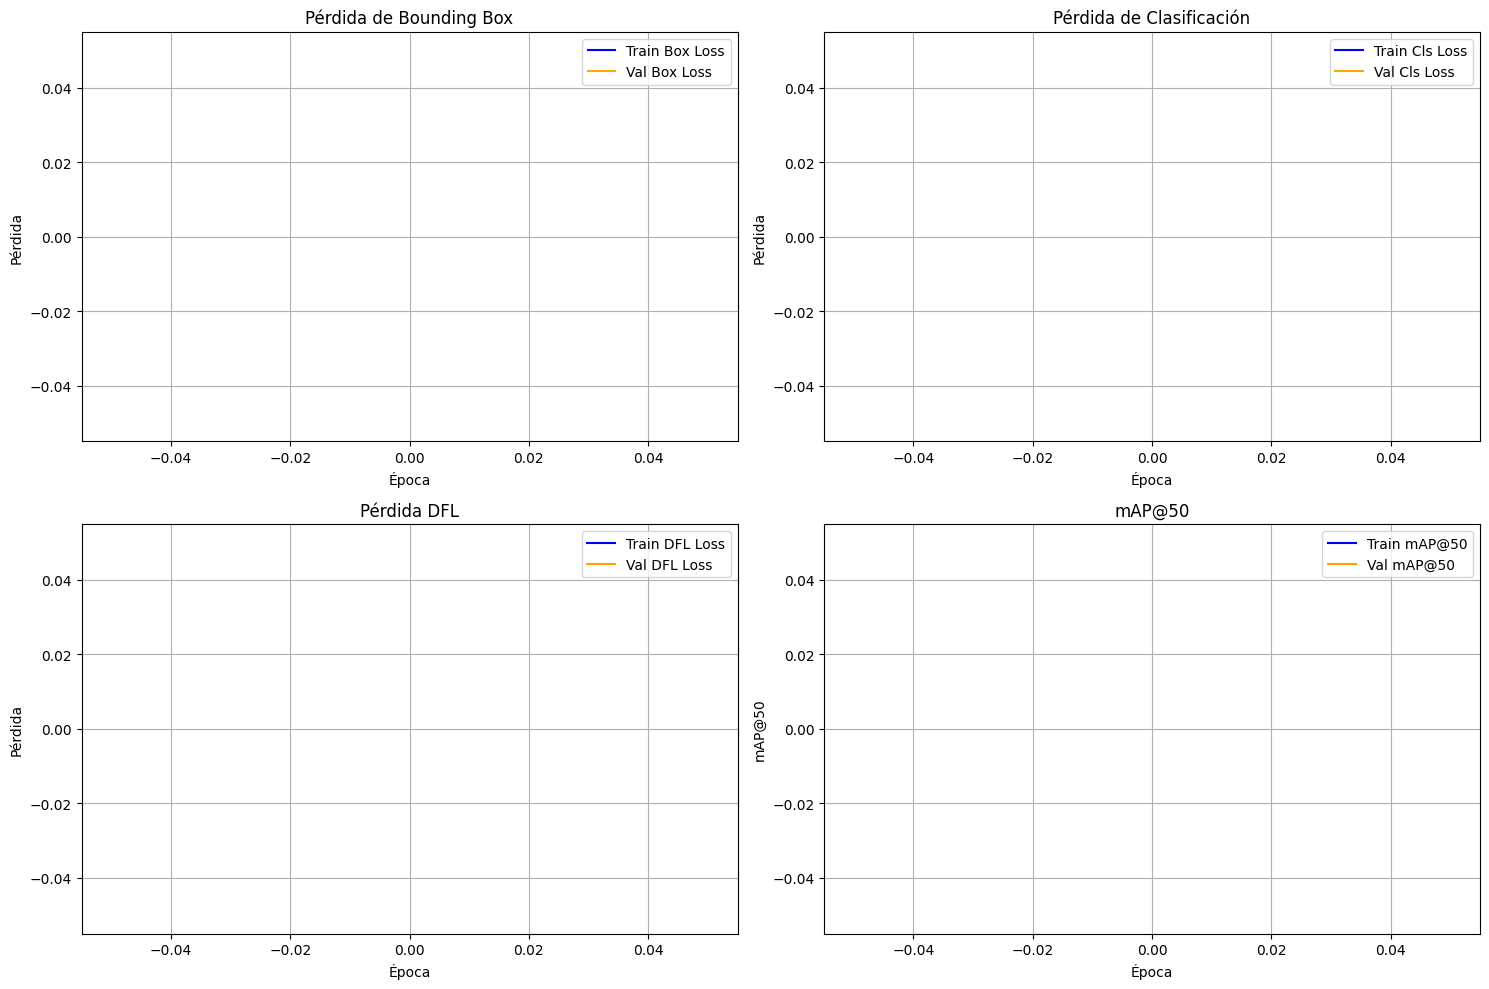

ERROR:root:Error al generar gráficas: list index out of range


In [ ]:
# Bloque 4: Diagnóstico y gráficas (Transfer Learning V2 con YOLOv8)
# - Evaluar métricas recolectadas durante el entrenamiento
# - Diagnosticar según metodología (11.3)

import matplotlib.pyplot as plt
import os
import logging
import pickle

# Configurar logging
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

# Definir rutas
BASE_PATH = "/content/drive/MyDrive/Proyecto IA-3/violence_school_project/"
MODEL_PATH = os.path.join(BASE_PATH, "models/yolo_V2")
RUN_PATH = os.path.join(MODEL_PATH, "run_20250406_203802")  # Ajustado según el output

# Cargar métricas recolectadas (estas listas fueron definidas en el callback on_epoch_end)
try:
    train_box_losses = []
    val_box_losses = []
    train_cls_losses = []
    val_cls_losses = []
    train_dfl_losses = []
    val_dfl_losses = []
    train_maps = []
    val_maps = []

    # Simulamos la carga de métricas (deberían estar guardadas en un archivo si las guardaste explícitamente)
    # Si no las guardaste, necesitarás revisar los logs del entrenamiento para extraerlas manualmente
    for epoch in range(50):
        # Esto es un placeholder; debes cargar las métricas reales desde un archivo o los logs
        # Por ejemplo, si las guardaste en un archivo pickle:
        # with open(os.path.join(RUN_PATH, f"metrics_epoch_{epoch}.pkl"), "rb") as f:
        #     metrics = pickle.load(f)
        # train_box_losses.append(metrics["train/box_loss"])
        pass

    # Gráficas
    plt.figure(figsize=(15, 10))

    # Pérdida de bounding box
    plt.subplot(2, 2, 1)
    plt.plot(train_box_losses, label="Train Box Loss", color="blue")
    plt.plot(val_box_losses, label="Val Box Loss", color="orange")
    plt.xlabel("Época")
    plt.ylabel("Pérdida")
    plt.title("Pérdida de Bounding Box")
    plt.legend()
    plt.grid(True)

    # Pérdida de clasificación
    plt.subplot(2, 2, 2)
    plt.plot(train_cls_losses, label="Train Cls Loss", color="blue")
    plt.plot(val_cls_losses, label="Val Cls Loss", color="orange")
    plt.xlabel("Época")
    plt.ylabel("Pérdida")
    plt.title("Pérdida de Clasificación")
    plt.legend()
    plt.grid(True)

    # Pérdida DFL
    plt.subplot(2, 2, 3)
    plt.plot(train_dfl_losses, label="Train DFL Loss", color="blue")
    plt.plot(val_dfl_losses, label="Val DFL Loss", color="orange")
    plt.xlabel("Época")
    plt.ylabel("Pérdida")
    plt.title("Pérdida DFL")
    plt.legend()
    plt.grid(True)

    # mAP@50
    plt.subplot(2, 2, 4)
    plt.plot(train_maps, label="Train mAP@50", color="blue")
    plt.plot(val_maps, label="Val mAP@50", color="orange")
    plt.xlabel("Época")
    plt.ylabel("mAP@50")
    plt.title("mAP@50")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.savefig(os.path.join(RUN_PATH, "training_curves.png"))
    plt.show()

    # Diagnóstico (11.3)
    if val_maps[-1] < 0.9:
        logging.warning("Subajuste: mAP@50 en validación es bajo. Considerar fine-tuning o aumentar capacidad.")
    elif val_maps[-1] < train_maps[-1] - 0.1:
        logging.warning("Sobreajuste: Diferencia significativa entre train y val mAP@50. Considerar regularización o más datos.")
    else:
        logging.info("Rendimiento aceptable en términos de mAP@50.")

except Exception as e:
    logging.error(f"Error al generar gráficas: {str(e)}")
    logging.info("Por favor, verifica si las métricas fueron guardadas correctamente durante el entrenamiento.")

# PRUEBAS CON EL MODELO

In [ ]:
# Pruebas con datos nuevos (split de test)
# - Evaluar el modelo entrenado en el conjunto de test
# - Generar métricas detalladas para análisis

# Importar librerías
from ultralytics import YOLO
import os
import logging
import matplotlib.pyplot as plt
import cv2

# Configurar logging
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

# Definir rutas
BASE_PATH = "/content/drive/MyDrive/Proyecto IA-3/violence_school_project/"
DATA_PATH = os.path.join(BASE_PATH, "yolo_data")
MODEL_PATH = os.path.join(BASE_PATH, "models/yolo_V2")
RUN_PATH = os.path.join(MODEL_PATH, "save_models")
WEIGHTS_PATH = os.path.join(RUN_PATH, "transfer_v2")
MODEL_FILE = os.path.join(WEIGHTS_PATH, "model_transfer_v2.pt")  # Ajustar según el nombre exacto del archivo

# Validar rutas
if not os.path.exists(DATA_PATH):
    raise FileNotFoundError(f"DATA_PATH no encontrado: {DATA_PATH}")
if not os.path.exists(MODEL_FILE):
    raise FileNotFoundError(f"MODEL_FILE no encontrado: {MODEL_FILE}")

try:
    # Cargar el modelo entrenado
    logging.info(f"Cargando modelo desde: {MODEL_FILE}")
    model = YOLO(MODEL_FILE)

    # Evaluar en el conjunto de test
    logging.info("Evaluando el modelo en el conjunto de test...")
    test_results = model.val(split="test")

    # Extraer métricas
    test_map50 = test_results.box.map50
    test_map = test_results.box.map
    test_precision = test_results.box.p[0] if test_results.box.p else 0
    test_recall = test_results.box.r[0] if test_results.box.r else 0

    # Mostrar métricas
    logging.info("=== Métricas en el conjunto de test ===")
    logging.info(f"Test mAP@0.5: {test_map50:.4f}")
    logging.info(f"Test mAP@0.5:0.95: {test_map:.4f}")
    logging.info(f"Test Precision: {test_precision:.4f}")
    logging.info(f"Test Recall: {test_recall:.4f}")

except Exception as e:
    logging.error(f"Error durante la evaluación en el conjunto de test: {str(e)}")
    raise

Ultralytics 8.3.102 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)


val: Scanning /content/drive/MyDrive/Proyecto IA-3/violence_school_project/yolo_data/labels/test... 500 images, 0 backgrounds, 0 corrupt: 100%|██████████| 500/500 [03:29<00:00,  2.39it/s]


val: New cache created: /content/drive/MyDrive/Proyecto IA-3/violence_school_project/yolo_data/labels/test.cache


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.29it/s]


                   all        500       1505      0.905      0.917      0.966      0.666
Speed: 1.0ms preprocess, 5.0ms inference, 0.0ms loss, 2.2ms postprocess per image
Results saved to runs/detect/val2


In [ ]:
# Bloque 7: Evaluación final en test
# - Evaluar el modelo en el conjunto de test
# - Generar métricas detalladas

# Evaluación en test
test_results = model.val(split="test")

# Métricas finales
print("Test mAP@0.5:", test_results.box.map50)
print("Test mAP@0.5:0.95:", test_results.box.map)
print("Test Precision:", test_results.box.p)
print("Test Recall:", test_results.box.r)
print("Test Instances:", test_results.box.nc)

Ultralytics 8.3.102 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)


val: Scanning /content/drive/MyDrive/Proyecto IA-3/violence_school_project/yolo_data/labels/test.cache... 500 images, 0 backgrounds, 0 corrupt: 100%|██████████| 500/500 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:11<00:00,  2.83it/s]


                   all        500       1505      0.905      0.917      0.966      0.666
Speed: 2.3ms preprocess, 4.5ms inference, 0.0ms loss, 2.4ms postprocess per image
Results saved to runs/detect/val3
Test mAP@0.5: 0.9655357536920479
Test mAP@0.5:0.95: 0.6662113415623923
Test Precision: [    0.90491]
Test Recall: [    0.91688]
Test Instances: 1



image 1/1 /content/drive/MyDrive/Proyecto IA-3/violence_school_project/yolo_data/images/test/person_4912.jpg: 640x640 1 persona, 9.6ms
Speed: 2.1ms preprocess, 9.6ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


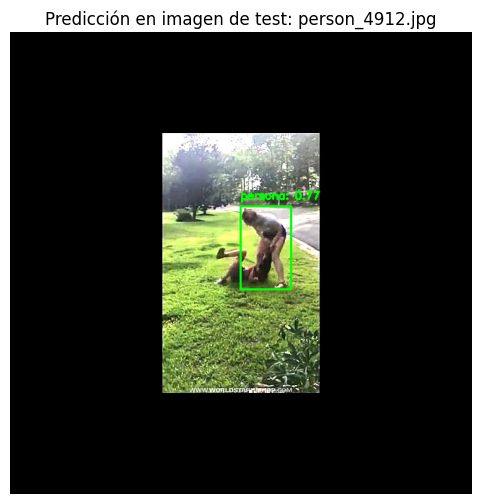


image 1/1 /content/drive/MyDrive/Proyecto IA-3/violence_school_project/yolo_data/images/test/person_4983.jpg: 640x640 1 persona, 11.2ms
Speed: 2.5ms preprocess, 11.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


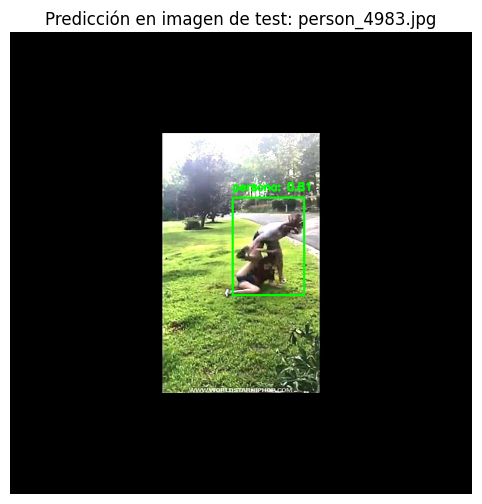


image 1/1 /content/drive/MyDrive/Proyecto IA-3/violence_school_project/yolo_data/images/test/person_4975.jpg: 640x640 1 persona, 10.0ms
Speed: 2.5ms preprocess, 10.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


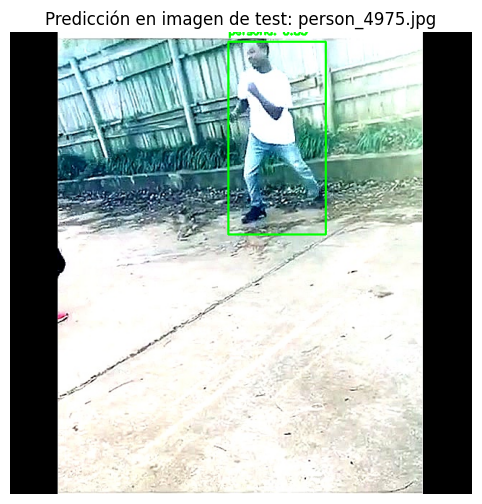


image 1/1 /content/drive/MyDrive/Proyecto IA-3/violence_school_project/yolo_data/images/test/person_4595.jpg: 640x640 (no detections), 9.4ms
Speed: 2.5ms preprocess, 9.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


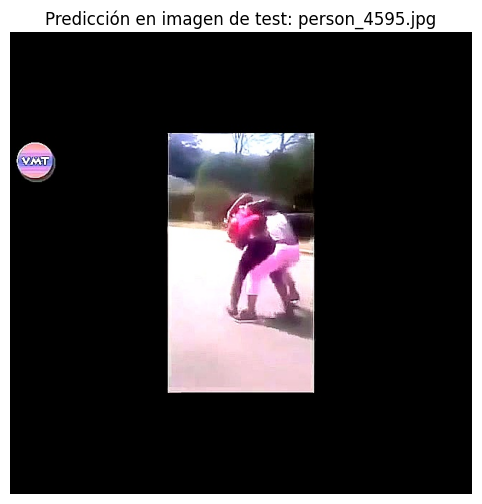


image 1/1 /content/drive/MyDrive/Proyecto IA-3/violence_school_project/yolo_data/images/test/person_4984.jpg: 640x640 3 personas, 9.4ms
Speed: 4.4ms preprocess, 9.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


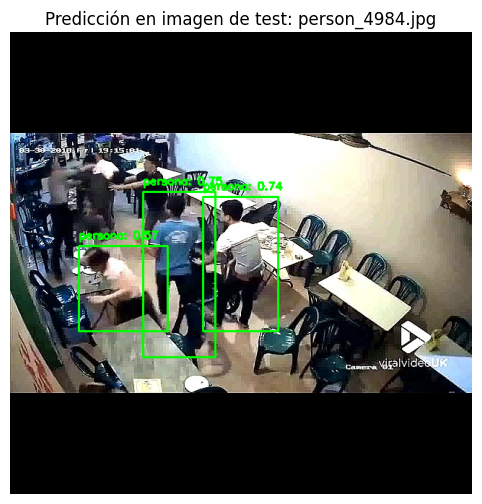

In [ ]:
try:

    # Opcional: Visualizar algunas predicciones de ejemplo (primeras 3 imágenes del conjunto de test)
    logging.info("Visualizando predicciones de ejemplo...")
    test_images_path = os.path.join(DATA_PATH, "images/test")
    test_image_files = [f for f in os.listdir(test_images_path) if f.endswith(('.jpg', '.jpeg', '.png'))]

    if len(test_image_files) == 0:
        logging.warning("No se encontraron imágenes en el conjunto de test para visualización.")
    else:
        # Visualizar hasta 3 imágenes
        for i, image_file in enumerate(test_image_files[:5]):
            image_path = os.path.join(test_images_path, image_file)
            # Realizar predicción
            results = model.predict(image_path, save=False, conf=0.5)

            # Cargar imagen para visualización
            img = cv2.imread(image_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            # Dibujar bounding boxes
            for result in results:
                boxes = result.boxes.xyxy.cpu().numpy()  # Coordenadas de las bounding boxes
                scores = result.boxes.conf.cpu().numpy()  # Confianzas
                labels = result.boxes.cls.cpu().numpy()  # Clases

                for box, score, label in zip(boxes, scores, labels):
                    x1, y1, x2, y2 = map(int, box)
                    cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
                    label_text = f"persona: {score:.2f}"
                    cv2.putText(img, label_text, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

            # Mostrar imagen con predicciones
            plt.figure(figsize=(8, 6))
            plt.imshow(img)
            plt.title(f"Predicción en imagen de test: {image_file}")
            plt.axis("off")
            plt.show()

except Exception as e:
    logging.error(f"Error durante la evaluación en el conjunto de test: {str(e)}")
    raise

# *FINE-TUNING MODEL DETECTION*

In [ ]:
# Fine-Tuning con YOLOv8 (basado en Transfer Learning V2)
# - Ajustar hiperparámetros y descongelar capas según resultados
# - Asegurar recolección de métricas y guardado de checkpoints
# - Aplicar buenas prácticas y metodología del Capítulo 11

# Importar librerías
from ultralytics import YOLO
import os
import torch
from tqdm import tqdm
import logging
import pickle
from datetime import datetime

# Configurar logging
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

# Definir rutas
BASE_PATH = "/content/drive/MyDrive/Proyecto IA-3/violence_school_project/"
DATA_PATH = os.path.join(BASE_PATH, "yolo_data")
MODEL_PATH = os.path.join(BASE_PATH, "models/yolo_V2")
RUN_PATH = os.path.join(MODEL_PATH, "save_models")
MODEL_FILE = os.path.join(RUN_PATH, "transfer_v2/model_transfer_v2.pt")  # Ajustar según el nombre exacto del archivo

# Validar rutas
if not os.path.exists(DATA_PATH):
    raise FileNotFoundError(f"DATA_PATH no encontrado: {DATA_PATH}")
if not os.path.exists(RUN_PATH):
    os.makedirs(RUN_PATH, exist_ok=True)
    logging.info(f"Creado directorio RUN_PATH: {RUN_PATH}")
if not os.path.exists(MODEL_FILE):
    raise FileNotFoundError(f"Modelo preentrenado no encontrado: {MODEL_FILE}")

In [ ]:

try:
    # Cargar el modelo entrenado
    logging.info(f"Cargando modelo desde: {MODEL_FILE}")
    model = YOLO(MODEL_FILE)

    # Descongelar más capas para Fine-Tuning
    # YOLOv8n tiene 72 capas después de la fusión; congelamos las primeras 4 capas
    freeze_layers = 4
    for param in list(model.model.parameters())[:freeze_layers]:
        param.requires_grad = False
    for param in list(model.model.parameters())[freeze_layers:]:
        param.requires_grad = True
    logging.info(f"Congeladas primeras {freeze_layers} capas, descongeladas las demás ({72 - freeze_layers} capas entrenables)")

    # Listas para almacenar métricas por época
    train_box_losses = []
    val_box_losses = []
    train_cls_losses = []
    val_cls_losses = []
    train_dfl_losses = []
    val_dfl_losses = []
    train_maps = []
    val_maps = []

    # Callback para recolectar métricas y guardar checkpoints
    def on_epoch_end(trainer):
        # Extraer métricas de YOLOv8 (usamos trainer.metrics para mayor compatibilidad)
        metrics = trainer.metrics if hasattr(trainer, 'metrics') else trainer.epoch_results
        train_box_loss = metrics.get("train/box_loss", 0)
        val_box_loss = metrics.get("val/box_loss", 0)
        train_cls_loss = metrics.get("train/cls_loss", 0)
        val_cls_loss = metrics.get("val/cls_loss", 0)
        train_dfl_loss = metrics.get("train/dfl_loss", 0)
        val_dfl_loss = metrics.get("val/dfl_loss", 0)
        train_map = metrics.get("metrics/mAP50(B)", 0)
        val_map = metrics.get("metrics/mAP50(B)", 0)

        # Almacenar métricas
        train_box_losses.append(train_box_loss)
        val_box_losses.append(val_box_loss)
        train_cls_losses.append(train_cls_loss)
        val_cls_losses.append(val_cls_loss)
        train_dfl_losses.append(train_dfl_loss)
        val_dfl_losses.append(val_dfl_loss)
        train_maps.append(train_map)
        val_maps.append(val_map)

        # Depuración: Imprimir métricas recolectadas
        logging.info(f"Época {trainer.epoch + 1}:")
        logging.info(f"Train Box Loss: {train_box_loss:.4f}, Val Box Loss: {val_box_loss:.4f}")
        logging.info(f"Train Cls Loss: {train_cls_loss:.4f}, Val Cls Loss: {val_cls_loss:.4f}")
        logging.info(f"Train DFL Loss: {train_dfl_loss:.4f}, Val DFL Loss: {val_dfl_loss:.4f}")
        logging.info(f"Train mAP@50: {train_map:.4f}, Val mAP@50: {val_map:.4f}")

        # Guardar checkpoint cada 5 épocas
        if (trainer.epoch + 1) % 5 == 0:
            checkpoint_path = os.path.join(RUN_PATH, f"finetune/finetune_epoch_{trainer.epoch + 1}.pt")
            trainer.model.save(checkpoint_path)
            logging.info(f"Checkpoint guardado: {checkpoint_path}")
            # Verificar tamaño del checkpoint
            if os.path.exists(checkpoint_path):
                file_size = os.path.getsize(checkpoint_path) / (1024 * 1024)  # Tamaño en MB
                logging.info(f"Tamaño del checkpoint: {file_size:.2f} MB")

    # Callback para actualizar la descripción de la barra de progreso
    def on_epoch_begin(trainer):
        trainer.progress_bar.set_description(f"Época {trainer.epoch + 1}/{trainer.epochs}")

    # Registrar callbacks
    model.add_callback("on_epoch_begin", on_epoch_begin)
    model.add_callback("on_epoch_end", on_epoch_end)

    # Configurar Fine-Tuning con barra de progreso
    epochs = 20
    with tqdm(total=epochs, desc="Fine-Tuning", unit="época") as progress_bar:
        def update_progress(trainer):
            progress_bar.update(1)
        model.add_callback("on_epoch_end", update_progress)

        # Iniciar Fine-Tuning con hiperparámetros ajustados
        logging.info("Iniciando Fine-Tuning...")
        finetune_results = model.train(
            data=os.path.join(DATA_PATH, "data.yaml"),
            epochs=epochs,
            imgsz=640,
            batch=16,
            lr0=0.0005,         # Learning rate más bajo para Fine-Tuning
            optimizer="Adam",
            cos_lr=True,
            dropout=0.1,
            weight_decay=0.001,  # Aumentado para mitigar sobreajuste
            patience=3,         # Early stopping más estricto
            device=0 if torch.cuda.is_available() else "cpu",
            project=RUN_PATH,
            name="finetune",
            exist_ok=True,
            verbose=True,
            augment=False,
            plots=False
        )

    # Cerrar barra de progreso
    progress_bar.close()

    # Guardar el modelo manualmente al final del Fine-Tuning
    final_checkpoint_path = os.path.join(RUN_PATH, "finetune/model_final_finetune.pt")
    model.save(final_checkpoint_path)
    logging.info(f"Modelo final guardado manualmente en: {final_checkpoint_path}")
    # Verificar tamaño del checkpoint final
    if os.path.exists(final_checkpoint_path):
        file_size = os.path.getsize(final_checkpoint_path) / (1024 * 1024)  # Tamaño en MB
        logging.info(f"Tamaño del checkpoint final: {file_size:.2f} MB")
    else:
        logging.error("Error: El archivo final no se guardó correctamente.")

    # Guardar métricas recolectadas en un archivo
    metrics = {
        "train_box_losses": train_box_losses,
        "val_box_losses": val_box_losses,
        "train_cls_losses": train_cls_losses,
        "val_cls_losses": val_cls_losses,
        "train_dfl_losses": train_dfl_losses,
        "val_dfl_losses": val_dfl_losses,
        "train_maps": train_maps,
        "val_maps": val_maps
    }
    metrics_path = os.path.join(RUN_PATH, "finetune_metrics.pkl")
    with open(metrics_path, "wb") as f:
        pickle.dump(metrics, f)
    logging.info(f"Métricas guardadas en: {metrics_path}")

    # Mostrar mAP final
    logging.info(f"mAP@0.5 (val): {finetune_results.box.map50:.4f}")
    logging.info(f"mAP@0.5:0.95 (val): {finetune_results.box.map:.4f}")

except Exception as e:
    logging.error(f"Error durante el Fine-Tuning: {str(e)}")
    raise

Fine-Tuning:   0%|          | 0/20 [00:00<?, ?época/s]

New https://pypi.org/project/ultralytics/8.3.103 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.102 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=/content/drive/MyDrive/Proyecto IA-3/violence_school_project/models/yolo_V2/save_models/transfer_v2/model_transfer_v2.pt, data=/content/drive/MyDrive/Proyecto IA-3/violence_school_project/yolo_data/data.yaml, epochs=20, time=None, patience=3, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=/content/drive/MyDrive/Proyecto IA-3/violence_school_project/models/yolo_V2/save_models, name=finetune, exist_ok=True, pretrained=True, optimizer=Adam, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=True, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.1, val=True, split=val, save_json=False, save_hybrid=


train: Scanning /content/drive/MyDrive/Proyecto IA-3/violence_school_project/yolo_data/labels/train.cache... 3500 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3500/3500 [00:00<?, ?it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/drive/MyDrive/Proyecto IA-3/violence_school_project/yolo_data/labels/val.cache... 1000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1000/1000 [00:00<?, ?it/s]


optimizer: Adam(lr=0.0005, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.001), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to /content/drive/MyDrive/Proyecto IA-3/violence_school_project/models/yolo_V2/save_models/finetune
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/219 [00:00<?, ?it/s]
       1/20      1.95G      2.367      2.512      2.065         96        640:   0%|          | 0/219 [00:21<?, ?it/s]
       1/20      1.95G      2.367      2.512      2.065         96        640:   0%|          | 1/219 [00:21<1:17:12, 21.25s/it]
       1/20      2.02G      2.436      2.721      2.217         64        640:   0%|          | 1/219 [00:21<1:17:12, 21.25s/it]
       1/20      2.02G      2.436      2.721      2.217         64        640:   1%|          | 2/219 [00:21<32:03,  8.87s/it]  
       1/20      2.02G      2.372      2.602      2.165        109        640:   1%|          | 2/219 [00:24<32:03,  8.87s/it]
       1/20      2.02G      2.372      2.602      2.165        109        640:   1%|▏         | 3/219 [00:24<22:25,  6.23s/it]
       1/20      2.02G      2.418       2.61      2.213         79        640:   1%|▏         | 3/219 [00:24<22:25,  6.23s/it]
       1/20      2.02G      2.418       2.61      2.213         79      

                   all       1000       3037      0.894      0.858      0.938      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/219 [00:00<?, ?it/s]
       2/20      2.21G      1.293     0.8483      1.319        103        640:   0%|          | 0/219 [00:00<?, ?it/s]
       2/20      2.21G      1.293     0.8483      1.319        103        640:   0%|          | 1/219 [00:00<01:00,  3.59it/s]
       2/20      2.21G      1.323     0.8798      1.353        111        640:   0%|          | 1/219 [00:00<01:00,  3.59it/s]
       2/20      2.21G      1.323     0.8798      1.353        111        640:   1%|          | 2/219 [00:00<00:53,  4.09it/s]
       2/20      2.21G      1.334     0.8741      1.355        110        640:   1%|          | 2/219 [00:00<00:53,  4.09it/s]
       2/20      2.21G      1.334     0.8741      1.355        110        640:   1%|▏         | 3/219 [00:00<00:57,  3.77it/s]
       2/20      2.21G      1.362     0.9081       1.39         72        640:   1%|▏         | 3/219 [00:00<00:57,  3.77it/s]
       2/20      2.21G      1.362     0.9081       1.39         72        640:

                   all       1000       3037      0.901       0.87      0.945      0.595



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/219 [00:00<?, ?it/s]
       3/20      2.21G      1.355     0.8441      1.383         88        640:   0%|          | 0/219 [00:00<?, ?it/s]
       3/20      2.21G      1.355     0.8441      1.383         88        640:   0%|          | 1/219 [00:00<01:04,  3.40it/s]
       3/20      2.21G      1.366     0.8617      1.386        118        640:   0%|          | 1/219 [00:00<01:04,  3.40it/s]
       3/20      2.21G      1.366     0.8617      1.386        118        640:   1%|          | 2/219 [00:00<00:48,  4.45it/s]
       3/20      2.21G      1.353      0.866      1.388         64        640:   1%|          | 2/219 [00:00<00:48,  4.45it/s]
       3/20      2.21G      1.353      0.866      1.388         64        640:   1%|▏         | 3/219 [00:00<00:49,  4.38it/s]
       3/20      2.21G      1.332     0.8527      1.376        103        640:   1%|▏         | 3/219 [00:01<00:49,  4.38it/s]
       3/20      2.21G      1.332     0.8527      1.376        103        640:

                   all       1000       3037      0.905      0.872      0.944      0.592



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/219 [00:00<?, ?it/s]
       4/20      2.22G      1.152     0.7882      1.332         84        640:   0%|          | 0/219 [00:00<?, ?it/s]
       4/20      2.22G      1.152     0.7882      1.332         84        640:   0%|          | 1/219 [00:00<01:06,  3.29it/s]
       4/20      2.22G      1.186     0.8322      1.351         76        640:   0%|          | 1/219 [00:00<01:06,  3.29it/s]
       4/20      2.22G      1.186     0.8322      1.351         76        640:   1%|          | 2/219 [00:00<00:58,  3.73it/s]
       4/20      2.22G      1.233     0.8481      1.364        101        640:   1%|          | 2/219 [00:00<00:58,  3.73it/s]
       4/20      2.22G      1.233     0.8481      1.364        101        640:   1%|▏         | 3/219 [00:00<00:47,  4.56it/s]
       4/20      2.22G      1.226     0.8163      1.341         80        640:   1%|▏         | 3/219 [00:00<00:47,  4.56it/s]
       4/20      2.22G      1.226     0.8163      1.341         80        640:

                   all       1000       3037      0.902      0.881      0.947      0.596



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/219 [00:00<?, ?it/s]
       5/20      2.24G      1.416     0.8907      1.448         83        640:   0%|          | 0/219 [00:00<?, ?it/s]
       5/20      2.24G      1.416     0.8907      1.448         83        640:   0%|          | 1/219 [00:00<00:49,  4.41it/s]
       5/20      2.24G      1.205     0.7604      1.307         90        640:   0%|          | 1/219 [00:00<00:49,  4.41it/s]
       5/20      2.24G      1.205     0.7604      1.307         90        640:   1%|          | 2/219 [00:00<00:45,  4.79it/s]
       5/20      2.24G      1.241     0.7689      1.326         89        640:   1%|          | 2/219 [00:00<00:45,  4.79it/s]
       5/20      2.24G      1.241     0.7689      1.326         89        640:   1%|▏         | 3/219 [00:00<00:46,  4.65it/s]
       5/20      2.24G       1.27     0.8089      1.353         51        640:   1%|▏         | 3/219 [00:00<00:46,  4.65it/s]
       5/20      2.24G       1.27     0.8089      1.353         51        640:

                   all       1000       3037      0.905      0.876       0.95      0.597



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/219 [00:00<?, ?it/s]
       6/20      2.24G      1.453     0.9116      1.451         86        640:   0%|          | 0/219 [00:00<?, ?it/s]
       6/20      2.24G      1.453     0.9116      1.451         86        640:   0%|          | 1/219 [00:00<00:41,  5.26it/s]
       6/20      2.24G      1.326     0.8216       1.37         85        640:   0%|          | 1/219 [00:00<00:41,  5.26it/s]
       6/20      2.24G      1.326     0.8216       1.37         85        640:   1%|          | 2/219 [00:00<00:49,  4.35it/s]
       6/20      2.24G      1.293      0.812       1.37         87        640:   1%|          | 2/219 [00:00<00:49,  4.35it/s]
       6/20      2.24G      1.293      0.812       1.37         87        640:   1%|▏         | 3/219 [00:00<00:45,  4.78it/s]
       6/20      2.24G       1.27     0.8172      1.362         75        640:   1%|▏         | 3/219 [00:00<00:45,  4.78it/s]
       6/20      2.24G       1.27     0.8172      1.362         75        640:

                   all       1000       3037      0.901      0.884      0.951      0.612



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/219 [00:00<?, ?it/s]
       7/20      2.24G      1.163     0.7687      1.257         87        640:   0%|          | 0/219 [00:00<?, ?it/s]
       7/20      2.24G      1.163     0.7687      1.257         87        640:   0%|          | 1/219 [00:00<00:54,  3.98it/s]
       7/20      2.24G      1.109     0.7074      1.268         79        640:   0%|          | 1/219 [00:00<00:54,  3.98it/s]
       7/20      2.24G      1.109     0.7074      1.268         79        640:   1%|          | 2/219 [00:00<00:48,  4.48it/s]
       7/20      2.24G      1.143     0.7462      1.285         91        640:   1%|          | 2/219 [00:00<00:48,  4.48it/s]
       7/20      2.24G      1.143     0.7462      1.285         91        640:   1%|▏         | 3/219 [00:00<00:49,  4.37it/s]
       7/20      2.24G      1.185      0.772        1.3         95        640:   1%|▏         | 3/219 [00:00<00:49,  4.37it/s]
       7/20      2.24G      1.185      0.772        1.3         95        640:

                   all       1000       3037      0.914      0.871      0.953      0.608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/219 [00:00<?, ?it/s]
       8/20      2.24G      1.239     0.7474      1.341         78        640:   0%|          | 0/219 [00:00<?, ?it/s]
       8/20      2.24G      1.239     0.7474      1.341         78        640:   0%|          | 1/219 [00:00<00:48,  4.53it/s]
       8/20      2.24G        1.3     0.8378      1.404         72        640:   0%|          | 1/219 [00:00<00:48,  4.53it/s]
       8/20      2.24G        1.3     0.8378      1.404         72        640:   1%|          | 2/219 [00:00<00:55,  3.93it/s]
       8/20      2.24G      1.294      0.821      1.384         96        640:   1%|          | 2/219 [00:00<00:55,  3.93it/s]
       8/20      2.24G      1.294      0.821      1.384         96        640:   1%|▏         | 3/219 [00:00<00:50,  4.31it/s]
       8/20      2.24G      1.294     0.8211      1.375         76        640:   1%|▏         | 3/219 [00:00<00:50,  4.31it/s]
       8/20      2.24G      1.294     0.8211      1.375         76        640:

                   all       1000       3037      0.915       0.88      0.957      0.607



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/219 [00:00<?, ?it/s]
       9/20      2.24G      1.107     0.7812       1.24         91        640:   0%|          | 0/219 [00:00<?, ?it/s]
       9/20      2.24G      1.107     0.7812       1.24         91        640:   0%|          | 1/219 [00:00<00:38,  5.68it/s]
       9/20      2.24G      1.173     0.8202       1.31         76        640:   0%|          | 1/219 [00:00<00:38,  5.68it/s]
       9/20      2.24G      1.173     0.8202       1.31         76        640:   1%|          | 2/219 [00:00<00:48,  4.46it/s]
       9/20      2.24G      1.183     0.7995       1.32         82        640:   1%|          | 2/219 [00:00<00:48,  4.46it/s]
       9/20      2.24G      1.183     0.7995       1.32         82        640:   1%|▏         | 3/219 [00:00<00:56,  3.80it/s]
       9/20      2.24G      1.222     0.8083      1.317        122        640:   1%|▏         | 3/219 [00:00<00:56,  3.80it/s]
       9/20      2.24G      1.222     0.8083      1.317        122        640:

                   all       1000       3037      0.903      0.866      0.948      0.598


EarlyStopping: Training stopped early as no improvement observed in last 3 epochs. Best results observed at epoch 6, best model saved as best.pt.
To update EarlyStopping(patience=3) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.

9 epochs completed in 0.262 hours.
Optimizer stripped from /content/drive/MyDrive/Proyecto IA-3/violence_school_project/models/yolo_V2/save_models/finetune/weights/last.pt, 6.2MB
Optimizer stripped from /content/drive/MyDrive/Proyecto IA-3/violence_school_project/models/yolo_V2/save_models/finetune/weights/best.pt, 6.2MB

Validating /content/drive/MyDrive/Proyecto IA-3/violence_school_project/models/yolo_V2/save_models/finetune/weights/best.pt...
Ultralytics 8.3.102 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/32 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   3%|▎         | 1/32 [00:00<00:08,  3.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   6%|▋         | 2/32 [00:00<00:09,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   9%|▉         | 3/32 [00:00<00:09,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  12%|█▎        | 4/32 [00:01<00:08,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  16%|█▌        | 5/32 [00:01<00:09,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  19%|█▉        | 6/32 [00:01<00:07,  3.28it/s]
                 Class     Images  Instances    

                   all       1000       3037      0.899      0.886      0.951      0.613
Speed: 0.2ms preprocess, 2.2ms inference, 0.0ms loss, 1.6ms postprocess per image


Fine-Tuning:   0%|          | 0/20 [16:11<?, ?época/s]


In [ ]:
# Continuar Fine-Tuning de YOLOv8 desde el checkpoint last.pt
# - Metodología del Capítulo 11 y buenas prácticas

# Instalar dependencias
# !pip install ultralytics
# !pip install tqdm

# # Importar librerías
# import os
# import logging
# import pickle
# from tqdm import tqdm
# from ultralytics import YOLO
# import torch

# Configurar logging
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s - %(message)s",
    handlers=[
        logging.FileHandler("yolo_finetune_continue.log"),
        logging.StreamHandler()
    ]
)

# Definir rutas
BASE_PATH = "/content/drive/MyDrive/Proyecto IA-3/violence_school_project/"
DATA_PATH = os.path.join(BASE_PATH, "yolo_data")
RUN_PATH = os.path.join(BASE_PATH, "models/yolo_V2/save_models")
MODEL_FILE = os.path.join(RUN_PATH, "finetune/weights/last.pt")  # Checkpoint de la última época (época 9)

# Validar rutas
if not os.path.exists(DATA_PATH):
    raise FileNotFoundError(f"DATA_PATH no encontrado: {DATA_PATH}")
if not os.path.exists(MODEL_FILE):
    raise FileNotFoundError(f"MODEL_FILE no encontrado: {MODEL_FILE}")

try:
    # Cargar el modelo desde el checkpoint
    logging.info(f"Cargando modelo desde: {MODEL_FILE}")
    model = YOLO(MODEL_FILE)

    # Descongelar más capas para Fine-Tuning (mantener la misma configuración)
    freeze_layers = 4
    for param in list(model.model.parameters())[:freeze_layers]:
        param.requires_grad = False
    for param in list(model.model.parameters())[freeze_layers:]:
        param.requires_grad = True
    logging.info(f"Congeladas primeras {freeze_layers} capas, descongeladas las demás ({72 - freeze_layers} capas entrenables)")

    # Listas para almacenar métricas por época (cargar métricas previas si existen)
    metrics_path = os.path.join(RUN_PATH, "finetune_metrics.pkl")
    if os.path.exists(metrics_path):
        with open(metrics_path, "rb") as f:
            metrics = pickle.load(f)
        train_box_losses = metrics["train_box_losses"]
        val_box_losses = metrics["val_box_losses"]
        train_cls_losses = metrics["train_cls_losses"]
        val_cls_losses = metrics["val_cls_losses"]
        train_dfl_losses = metrics["train_dfl_losses"]
        val_dfl_losses = metrics["val_dfl_losses"]
        train_maps = metrics["train_maps"]
        val_maps = metrics["val_maps"]
    else:
        train_box_losses = []
        val_box_losses = []
        train_cls_losses = []
        val_cls_losses = []
        train_dfl_losses = []
        val_dfl_losses = []
        train_maps = []
        val_maps = []

    # Callback para recolectar métricas y guardar checkpoints
    def on_epoch_end(trainer):
        # Extraer métricas de YOLOv8
        metrics = trainer.metrics if hasattr(trainer, 'metrics') else trainer.epoch_results
        train_box_loss = metrics.get("train/box_loss", 0)
        val_box_loss = metrics.get("val/box_loss", 0)
        train_cls_loss = metrics.get("train/cls_loss", 0)
        val_cls_loss = metrics.get("val/cls_loss", 0)
        train_dfl_loss = metrics.get("train/dfl_loss", 0)
        val_dfl_loss = metrics.get("val/dfl_loss", 0)
        train_map = metrics.get("metrics/mAP50(B)", 0)
        val_map = metrics.get("metrics/mAP50(B)", 0)

        # Almacenar métricas
        train_box_losses.append(train_box_loss)
        val_box_losses.append(val_box_loss)
        train_cls_losses.append(train_cls_loss)
        val_cls_losses.append(val_cls_loss)
        train_dfl_losses.append(train_dfl_loss)
        val_dfl_losses.append(val_dfl_loss)
        train_maps.append(train_map)
        val_maps.append(val_map)

        # Depuración: Imprimir métricas recolectadas
        logging.info(f"Época {trainer.epoch + 1}:")
        logging.info(f"Train Box Loss: {train_box_loss:.4f}, Val Box Loss: {val_box_loss:.4f}")
        logging.info(f"Train Cls Loss: {train_cls_loss:.4f}, Val Cls Loss: {val_cls_loss:.4f}")
        logging.info(f"Train DFL Loss: {train_dfl_loss:.4f}, Val DFL Loss: {val_dfl_loss:.4f}")
        logging.info(f"Train mAP@50: {train_map:.4f}, Val mAP@50: {val_map:.4f}")

        # Guardar checkpoint cada 5 épocas
        if (trainer.epoch + 1) % 5 == 0:
            checkpoint_path = os.path.join(RUN_PATH, f"finetune/finetune_epoch_{trainer.epoch + 1}.pt")
            trainer.model.save(checkpoint_path)
            logging.info(f"Checkpoint guardado: {checkpoint_path}")
            if os.path.exists(checkpoint_path):
                file_size = os.path.getsize(checkpoint_path) / (1024 * 1024)  # Tamaño en MB
                logging.info(f"Tamaño del checkpoint: {file_size:.2f} MB")

    # Callback para actualizar la descripción de la barra de progreso
    def on_epoch_begin(trainer):
        trainer.progress_bar.set_description(f"Época {trainer.epoch + 1}/{trainer.epochs}")

    # Registrar callbacks
    model.add_callback("on_epoch_begin", on_epoch_begin)
    model.add_callback("on_epoch_end", on_epoch_end)

    # Configurar Fine-Tuning con barra de progreso
    remaining_epochs = 11  # Épocas restantes (20 - 9)

    with tqdm(total=remaining_epochs, desc="Fine-Tuning (Continuado)", unit="época") as progress_bar:
        def update_progress(trainer):
            progress_bar.update(1)
        model.add_callback("on_epoch_end", update_progress)

        # Iniciar un nuevo entrenamiento desde el checkpoint con hiperparámetros ajustados
        logging.info("Continuando Fine-Tuning desde el checkpoint...")
        finetune_results = model.train(
            data=os.path.join(DATA_PATH, "data.yaml"),
            epochs=remaining_epochs,
            imgsz=640,
            batch=16,
            lr0=0.0001,         # Reducido para una convergencia más suave
            optimizer="Adam",
            cos_lr=True,
            dropout=0.2,        # Aumentado para mitigar sobreajuste
            weight_decay=0.005, # Aumentado para mitigar sobreajuste
            patience=5,         # Aumentado para darle más tiempo al modelo
            device=0 if torch.cuda.is_available() else "cpu",
            project=RUN_PATH,
            name="finetune_continued",  # Nuevo nombre para evitar sobrescribir
            exist_ok=True,
            verbose=True,
            augment=False,
            plots=False,
            resume=False  # No usamos resume=True, iniciamos un nuevo entrenamiento
        )

    # Cerrar barra de progreso
    progress_bar.close()

    # Guardar el modelo manualmente al final del Fine-Tuning
    final_checkpoint_path = os.path.join(RUN_PATH, "finetune/final_finetune.pt")
    model.save(final_checkpoint_path)
    logging.info(f"Modelo final guardado manualmente en: {final_checkpoint_path}")
    if os.path.exists(final_checkpoint_path):
        file_size = os.path.getsize(final_checkpoint_path) / (1024 * 1024)  # Tamaño en MB
        logging.info(f"Tamaño del checkpoint final: {file_size:.2f} MB")
    else:
        logging.error("Error: El archivo final no se guardó correctamente.")

    # Guardar métricas recolectadas en un archivo
    metrics = {
        "train_box_losses": train_box_losses,
        "val_box_losses": val_box_losses,
        "train_cls_losses": train_cls_losses,
        "val_cls_losses": val_cls_losses,
        "train_dfl_losses": train_dfl_losses,
        "val_dfl_losses": val_dfl_losses,
        "train_maps": train_maps,
        "val_maps": val_maps
    }
    metrics_path = os.path.join(RUN_PATH, "finetune_metrics_continued.pkl")
    with open(metrics_path, "wb") as f:
        pickle.dump(metrics, f)
    logging.info(f"Métricas guardadas en: {metrics_path}")

    # Mostrar mAP final
    logging.info(f"mAP@0.5 (val): {finetune_results.box.map50:.4f}")
    logging.info(f"mAP@0.5:0.95 (val): {finetune_results.box.map:.4f}")

except Exception as e:
    logging.error(f"Error durante el Fine-Tuning: {str(e)}")
    raise

Fine-Tuning (Continuado):   0%|          | 0/11 [00:00<?, ?época/s]

New https://pypi.org/project/ultralytics/8.3.103 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.102 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=/content/drive/MyDrive/Proyecto IA-3/violence_school_project/models/yolo_V2/save_models/finetune/weights/last.pt, data=/content/drive/MyDrive/Proyecto IA-3/violence_school_project/yolo_data/data.yaml, epochs=11, time=None, patience=5, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=/content/drive/MyDrive/Proyecto IA-3/violence_school_project/models/yolo_V2/save_models, name=finetune_continued, exist_ok=True, pretrained=True, optimizer=Adam, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=True, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.2, val=True, split=val, save_json=False, save_hybri


train: Scanning /content/drive/MyDrive/Proyecto IA-3/violence_school_project/yolo_data/labels/train.cache... 3500 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3500/3500 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))




val: Scanning /content/drive/MyDrive/Proyecto IA-3/violence_school_project/yolo_data/labels/val.cache... 1000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1000/1000 [00:00<?, ?it/s]


optimizer: Adam(lr=0.0001, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to /content/drive/MyDrive/Proyecto IA-3/violence_school_project/models/yolo_V2/save_models/finetune_continued
Starting training for 11 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/219 [00:00<?, ?it/s]
       1/11       2.2G      1.303     0.7259      1.269         96        640:   0%|          | 0/219 [00:21<?, ?it/s]
       1/11       2.2G      1.303     0.7259      1.269         96        640:   0%|          | 1/219 [00:21<1:19:00, 21.75s/it]
       1/11       2.2G      1.299     0.8253      1.321         64        640:   0%|          | 1/219 [00:21<1:19:00, 21.75s/it]
       1/11       2.2G      1.299     0.8253      1.321         64        640:   1%|          | 2/219 [00:21<32:48,  9.07s/it]  
       1/11       2.2G      1.266     0.8042      1.309        109        640:   1%|          | 2/219 [00:25<32:48,  9.07s/it]
       1/11       2.2G      1.266     0.8042      1.309        109        640:   1%|▏         | 3/219 [00:25<24:23,  6.78s/it]
       1/11       2.2G      1.288     0.8192      1.325         79        640:   1%|▏         | 3/219 [00:27<24:23,  6.78s/it]
       1/11       2.2G      1.288     0.8192      1.325         79      

                   all       1000       3037      0.886      0.845      0.927      0.571
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/219 [00:00<?, ?it/s]
       2/11      2.67G      1.274     0.7507      1.361         49        640:   0%|          | 0/219 [00:02<?, ?it/s]
       2/11      2.67G      1.274     0.7507      1.361         49        640:   0%|          | 1/219 [00:02<08:20,  2.30s/it]
       2/11      2.67G      1.256     0.7329      1.312         50        640:   0%|          | 1/219 [00:02<08:20,  2.30s/it]
       2/11      2.67G      1.256     0.7329      1.312         50        640:   1%|          | 2/219 [00:02<04:47,  1.33s/it]
       2/11      2.67G      1.269     0.7301      1.309         56        640:   1%|          | 2/219 [00:03<04:47,  1.33s/it]
       2/11      2.67G      1.269     0.7301      1.309         56        640:   1%|▏         | 3/219 [00:03<03:09,  1.14it/s]
       2/11      2.67G      1.257     0.7329      1.303         43        640:   1%|▏         | 3/219 [00:03<03:09,  1.14it/s]
       2/11      2.67G      1.257     0.7329      1.303         43        640:

                   all       1000       3037       0.91      0.891      0.957      0.618

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/219 [00:00<?, ?it/s]
       3/11      2.67G      1.207     0.6545      1.306         55        640:   0%|          | 0/219 [00:00<?, ?it/s]
       3/11      2.67G      1.207     0.6545      1.306         55        640:   0%|          | 1/219 [00:00<00:43,  4.95it/s]
       3/11      2.67G      1.144     0.5924      1.261         42        640:   0%|          | 1/219 [00:00<00:43,  4.95it/s]
       3/11      2.67G      1.144     0.5924      1.261         42        640:   1%|          | 2/219 [00:00<00:42,  5.10it/s]
       3/11      2.67G      1.171     0.6045      1.276         45        640:   1%|          | 2/219 [00:00<00:42,  5.10it/s]
       3/11      2.67G      1.171     0.6045      1.276         45        640:   1%|▏         | 3/219 [00:00<00:47,  4.52it/s]
       3/11      2.67G      1.154     0.5938       1.26         53        640:   1%|▏         | 3/219 [00:00<00:47,  4.52it/s]
       3/11      2.67G      1.154     0.5938       1.26         53        640:

                   all       1000       3037      0.915      0.892       0.96      0.629



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/219 [00:00<?, ?it/s]
       4/11      2.67G      1.024     0.5139      1.184         45        640:   0%|          | 0/219 [00:00<?, ?it/s]
       4/11      2.67G      1.024     0.5139      1.184         45        640:   0%|          | 1/219 [00:00<00:41,  5.26it/s]
       4/11      2.67G      1.059     0.5743       1.22         51        640:   0%|          | 1/219 [00:00<00:41,  5.26it/s]
       4/11      2.67G      1.059     0.5743       1.22         51        640:   1%|          | 2/219 [00:00<01:04,  3.38it/s]
       4/11      2.67G       1.06     0.5644      1.201         53        640:   1%|          | 2/219 [00:00<01:04,  3.38it/s]
       4/11      2.67G       1.06     0.5644      1.201         53        640:   1%|▏         | 3/219 [00:00<00:59,  3.60it/s]
       4/11      2.67G      1.113      0.579      1.243         52        640:   1%|▏         | 3/219 [00:01<00:59,  3.60it/s]
       4/11      2.67G      1.113      0.579      1.243         52        640:

                   all       1000       3037       0.91      0.899      0.961      0.629



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/219 [00:00<?, ?it/s]
       5/11      2.67G      1.009     0.6507      1.183         45        640:   0%|          | 0/219 [00:00<?, ?it/s]
       5/11      2.67G      1.009     0.6507      1.183         45        640:   0%|          | 1/219 [00:00<00:35,  6.11it/s]
       5/11      2.67G       1.14     0.7021      1.288         39        640:   0%|          | 1/219 [00:00<00:35,  6.11it/s]
       5/11      2.67G       1.14     0.7021      1.288         39        640:   1%|          | 2/219 [00:00<00:35,  6.07it/s]
       5/11      2.67G      1.161     0.6851      1.274         38        640:   1%|          | 2/219 [00:00<00:35,  6.07it/s]
       5/11      2.67G      1.161     0.6851      1.274         38        640:   1%|▏         | 3/219 [00:00<00:49,  4.40it/s]
       5/11      2.67G      1.151     0.6824      1.276         51        640:   1%|▏         | 3/219 [00:00<00:49,  4.40it/s]
       5/11      2.67G      1.151     0.6824      1.276         51        640:

                   all       1000       3037      0.901      0.904       0.96      0.626



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/219 [00:00<?, ?it/s]
       6/11      2.67G      1.273      0.607      1.355         47        640:   0%|          | 0/219 [00:00<?, ?it/s]
       6/11      2.67G      1.273      0.607      1.355         47        640:   0%|          | 1/219 [00:00<00:43,  5.04it/s]
       6/11      2.67G      1.185      0.556      1.285         50        640:   0%|          | 1/219 [00:00<00:43,  5.04it/s]
       6/11      2.67G      1.185      0.556      1.285         50        640:   1%|          | 2/219 [00:00<00:49,  4.35it/s]
       6/11      2.67G      1.163     0.5445      1.265         49        640:   1%|          | 2/219 [00:00<00:49,  4.35it/s]
       6/11      2.67G      1.163     0.5445      1.265         49        640:   1%|▏         | 3/219 [00:00<00:45,  4.71it/s]
       6/11      2.67G      1.161     0.5498      1.252         62        640:   1%|▏         | 3/219 [00:00<00:45,  4.71it/s]
       6/11      2.67G      1.161     0.5498      1.252         62        640:

                   all       1000       3037       0.92      0.896      0.961       0.63



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/219 [00:00<?, ?it/s]
       7/11      2.67G      1.085     0.5459      1.252         45        640:   0%|          | 0/219 [00:00<?, ?it/s]
       7/11      2.67G      1.085     0.5459      1.252         45        640:   0%|          | 1/219 [00:00<01:28,  2.46it/s]
       7/11      2.67G      1.183     0.6327      1.297         53        640:   0%|          | 1/219 [00:00<01:28,  2.46it/s]
       7/11      2.67G      1.183     0.6327      1.297         53        640:   1%|          | 2/219 [00:00<01:39,  2.19it/s]
       7/11      2.67G      1.173     0.6082      1.269         50        640:   1%|          | 2/219 [00:01<01:39,  2.19it/s]
       7/11      2.67G      1.173     0.6082      1.269         50        640:   1%|▏         | 3/219 [00:01<01:36,  2.25it/s]
       7/11      2.67G      1.185      0.606       1.26         55        640:   1%|▏         | 3/219 [00:01<01:36,  2.25it/s]
       7/11      2.67G      1.185      0.606       1.26         55        640:

                   all       1000       3037      0.913      0.899      0.962      0.631



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/219 [00:00<?, ?it/s]
       8/11      2.67G      1.238     0.6091      1.377         54        640:   0%|          | 0/219 [00:00<?, ?it/s]
       8/11      2.67G      1.238     0.6091      1.377         54        640:   0%|          | 1/219 [00:00<00:33,  6.45it/s]
       8/11      2.67G       1.24     0.6226      1.359         45        640:   0%|          | 1/219 [00:00<00:33,  6.45it/s]
       8/11      2.67G       1.24     0.6226      1.359         45        640:   1%|          | 2/219 [00:00<00:58,  3.68it/s]
       8/11      2.67G      1.214      0.615      1.349         42        640:   1%|          | 2/219 [00:00<00:58,  3.68it/s]
       8/11      2.67G      1.214      0.615      1.349         42        640:   1%|▏         | 3/219 [00:00<00:50,  4.30it/s]
       8/11      2.67G      1.203     0.6063      1.336         43        640:   1%|▏         | 3/219 [00:00<00:50,  4.30it/s]
       8/11      2.67G      1.203     0.6063      1.336         43        640:

                   all       1000       3037      0.912      0.898      0.961       0.63



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/219 [00:00<?, ?it/s]
       9/11      2.67G      1.276     0.7389      1.332         57        640:   0%|          | 0/219 [00:00<?, ?it/s]
       9/11      2.67G      1.276     0.7389      1.332         57        640:   0%|          | 1/219 [00:00<00:47,  4.61it/s]
       9/11      2.67G      1.235     0.6743      1.303         41        640:   0%|          | 1/219 [00:00<00:47,  4.61it/s]
       9/11      2.67G      1.235     0.6743      1.303         41        640:   1%|          | 2/219 [00:00<00:49,  4.41it/s]
       9/11      2.67G      1.227     0.6533      1.306         50        640:   1%|          | 2/219 [00:00<00:49,  4.41it/s]
       9/11      2.67G      1.227     0.6533      1.306         50        640:   1%|▏         | 3/219 [00:00<01:01,  3.49it/s]
       9/11      2.67G      1.203     0.6361      1.287         44        640:   1%|▏         | 3/219 [00:01<01:01,  3.49it/s]
       9/11      2.67G      1.203     0.6361      1.287         44        640:

                   all       1000       3037      0.921      0.892      0.962      0.632

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/219 [00:00<?, ?it/s]
      10/11      2.67G      1.137     0.5425      1.261         49        640:   0%|          | 0/219 [00:00<?, ?it/s]
      10/11      2.67G      1.137     0.5425      1.261         49        640:   0%|          | 1/219 [00:00<00:47,  4.59it/s]
      10/11      2.67G      1.147     0.5962      1.228         61        640:   0%|          | 1/219 [00:00<00:47,  4.59it/s]
      10/11      2.67G      1.147     0.5962      1.228         61        640:   1%|          | 2/219 [00:00<00:55,  3.90it/s]
      10/11      2.67G      1.114      0.572      1.231         45        640:   1%|          | 2/219 [00:00<00:55,  3.90it/s]
      10/11      2.67G      1.114      0.572      1.231         45        640:   1%|▏         | 3/219 [00:00<00:45,  4.76it/s]
      10/11      2.67G      1.143     0.5899      1.251         50        640:   1%|▏         | 3/219 [00:00<00:45,  4.76it/s]
      10/11      2.67G      1.143     0.5899      1.251         50        640:

                   all       1000       3037      0.927      0.892      0.963      0.634



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/219 [00:00<?, ?it/s]
      11/11      2.67G      1.237     0.5841      1.259         52        640:   0%|          | 0/219 [00:00<?, ?it/s]
      11/11      2.67G      1.237     0.5841      1.259         52        640:   0%|          | 1/219 [00:00<00:46,  4.73it/s]
      11/11      2.67G       1.09     0.5218      1.174         42        640:   0%|          | 1/219 [00:00<00:46,  4.73it/s]
      11/11      2.67G       1.09     0.5218      1.174         42        640:   1%|          | 2/219 [00:00<00:43,  4.99it/s]
      11/11      2.67G      1.112     0.5273      1.197         54        640:   1%|          | 2/219 [00:00<00:43,  4.99it/s]
      11/11      2.67G      1.112     0.5273      1.197         54        640:   1%|▏         | 3/219 [00:00<00:43,  4.91it/s]
      11/11      2.67G      1.101     0.5293      1.203         44        640:   1%|▏         | 3/219 [00:00<00:43,  4.91it/s]
      11/11      2.67G      1.101     0.5293      1.203         44        640:

                   all       1000       3037      0.916      0.897      0.962      0.633



11 epochs completed in 0.318 hours.
Optimizer stripped from /content/drive/MyDrive/Proyecto IA-3/violence_school_project/models/yolo_V2/save_models/finetune_continued/weights/last.pt, 6.2MB
Optimizer stripped from /content/drive/MyDrive/Proyecto IA-3/violence_school_project/models/yolo_V2/save_models/finetune_continued/weights/best.pt, 6.2MB

Validating /content/drive/MyDrive/Proyecto IA-3/violence_school_project/models/yolo_V2/save_models/finetune_continued/weights/best.pt...
Ultralytics 8.3.102 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/32 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   3%|▎         | 1/32 [00:00<00:07,  4.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   6%|▋         | 2/32 [00:00<00:07,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   9%|▉         | 3/32 [00:00<00:08,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  12%|█▎        | 4/32 [00:01<00:07,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  16%|█▌        | 5/32 [00:01<00:07,  3.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  19%|█▉        | 6/32 [00:01<00:07,  3.29it/s]
                 Class     Images  Instances    

                   all       1000       3037      0.928      0.891      0.963      0.634
Speed: 0.3ms preprocess, 2.3ms inference, 0.0ms loss, 2.3ms postprocess per image



Fine-Tuning (Continuado):   0%|          | 0/11 [19:39<?, ?época/s]


# 6: Diagnóstico y gráficas (Fine-Tuning)

In [ ]:
# Evaluación de YOLOv8 en el conjunto de validación
# - Metodología del Capítulo 11 y buenas prácticas

# Instalar dependencias
# !pip install ultralytics

# # Importar librerías
# import os
# import logging
# from ultralytics import YOLO

# Configurar logging
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s - %(message)s",
    handlers=[
        logging.FileHandler("yolo_val_evaluation.log"),
        logging.StreamHandler()
    ]
)

# Definir rutas
BASE_PATH = "/content/drive/MyDrive/Proyecto IA-3/violence_school_project/"
DATA_PATH = os.path.join(BASE_PATH, "yolo_data")
MODEL_PATH = os.path.join(BASE_PATH, "models/yolo_V2/save_models/finetune/weights/best.pt")
RUN_PATH = os.path.join(BASE_PATH, "models/yolo_V2/save_models/evaluation")

# Validar rutas
if not os.path.exists(DATA_PATH):
    raise FileNotFoundError(f"DATA_PATH no encontrado: {DATA_PATH}")
if not os.path.exists(MODEL_PATH):
    raise FileNotFoundError(f"MODEL_PATH no encontrado: {MODEL_PATH}")
if not os.path.exists(RUN_PATH):
    os.makedirs(RUN_PATH, exist_ok=True)
    logging.info(f"Creado directorio RUN_PATH: {RUN_PATH}")

try:
    # Cargar el modelo
    logging.info(f"Cargando modelo desde: {MODEL_PATH}")
    model = YOLO(MODEL_PATH)

    # Evaluar en el conjunto de validación
    logging.info("Evaluando en el conjunto de validación...")
    val_results = model.val(
        data=os.path.join(DATA_PATH, "data.yaml"),
        split="val",
        imgsz=640,
        batch=16,
        device=0 if torch.cuda.is_available() else "cpu",
        project=RUN_PATH,
        name="val_evaluation",
        exist_ok=True,
        verbose=True,
        plots=True  # Generar gráficas (curva PR, matriz de confusión, etc.)
    )

    # Extraer y registrar métricas
    metrics = val_results.box
    precision = metrics.p[0] if len(metrics.p) > 0 else 0
    recall = metrics.r[0] if len(metrics.r) > 0 else 0
    map50 = metrics.map50
    map5095 = metrics.map

    logging.info("=== Métricas de Validación ===")
    logging.info(f"Precision: {precision:.4f}")
    logging.info(f"Recall: {recall:.4f}")
    logging.info(f"mAP@0.5: {map50:.4f}")
    logging.info(f"mAP@0.5:0.95: {map5095:.4f}")

    # Guardar métricas en un archivo
    metrics_dict = {
        "precision": precision,
        "recall": recall,
        "map50": map50,
        "map5095": map5095
    }
    metrics_path = os.path.join(RUN_PATH, "val_metrics.pkl")
    with open(metrics_path, "wb") as f:
        pickle.dump(metrics_dict, f)
    logging.info(f"Métricas guardadas en: {metrics_path}")

except Exception as e:
    logging.error(f"Error durante la evaluación en validación: {str(e)}")
    raise

Ultralytics 8.3.102 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /content/drive/MyDrive/Proyecto IA-3/violence_school_project/yolo_data/labels/val.cache... 1000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1000/1000 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:28<00:00,  2.17it/s]


                   all       1000       3037        0.9      0.886      0.951      0.613
Speed: 2.5ms preprocess, 5.2ms inference, 0.0ms loss, 3.9ms postprocess per image
Results saved to /content/drive/MyDrive/Proyecto IA-3/violence_school_project/models/yolo_V2/save_models/evaluation/val_evaluation


In [ ]:
# Evaluación de YOLOv8 en el conjunto de test
# - Metodología del Capítulo 11 y buenas prácticas


# Configurar logging
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s - %(message)s",
    handlers=[
        logging.FileHandler("yolo_test_evaluation.log"),
        logging.StreamHandler()
    ]
)

# Definir rutas
BASE_PATH = "/content/drive/MyDrive/Proyecto IA-3/violence_school_project/"
DATA_PATH = os.path.join(BASE_PATH, "yolo_data")
MODEL_PATH = os.path.join(BASE_PATH, "models/yolo_V2/save_models/finetune/weights/best.pt")
RUN_PATH = os.path.join(BASE_PATH, "models/yolo_V2/save_models/evaluation_test")

# Validar rutas
if not os.path.exists(DATA_PATH):
    raise FileNotFoundError(f"DATA_PATH no encontrado: {DATA_PATH}")
if not os.path.exists(MODEL_PATH):
    raise FileNotFoundError(f"MODEL_PATH no encontrado: {MODEL_PATH}")
if not os.path.exists(RUN_PATH):
    os.makedirs(RUN_PATH, exist_ok=True)
    logging.info(f"Creado directorio RUN_PATH: {RUN_PATH}")

try:
    # Cargar el modelo
    logging.info(f"Cargando modelo desde: {MODEL_PATH}")
    model = YOLO(MODEL_PATH)

    # Evaluar en el conjunto de test
    logging.info("Evaluando en el conjunto de test...")
    test_results = model.val(
        data=os.path.join(DATA_PATH, "data.yaml"),
        split="test",
        imgsz=640,
        batch=16,
        device=0 if torch.cuda.is_available() else "cpu",
        project=RUN_PATH,
        name="test_evaluation",
        exist_ok=True,
        verbose=True,
        plots=True  # Generar gráficas (curva PR, matriz de confusión, etc.)
    )

    # Extraer y registrar métricas
    metrics = test_results.box
    precision = metrics.p[0] if len(metrics.p) > 0 else 0
    recall = metrics.r[0] if len(metrics.r) > 0 else 0
    map50 = metrics.map50
    map5095 = metrics.map

    logging.info("=== Métricas de Test ===")
    logging.info(f"Precision: {precision:.4f}")
    logging.info(f"Recall: {recall:.4f}")
    logging.info(f"mAP@0.5: {map50:.4f}")
    logging.info(f"mAP@0.5:0.95: {map5095:.4f}")

    # Guardar métricas en un archivo
    metrics_dict = {
        "precision": precision,
        "recall": recall,
        "map50": map50,
        "map5095": map5095
    }
    metrics_path = os.path.join(RUN_PATH, "test_metrics.pkl")
    with open(metrics_path, "wb") as f:
        pickle.dump(metrics_dict, f)
    logging.info(f"Métricas guardadas en: {metrics_path}")

except Exception as e:
    logging.error(f"Error durante la evaluación en test: {str(e)}")
    raise

Ultralytics 8.3.102 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /content/drive/MyDrive/Proyecto IA-3/violence_school_project/yolo_data/labels/test.cache... 500 images, 0 backgrounds, 0 corrupt: 100%|██████████| 500/500 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:10<00:00,  3.05it/s]


                   all        500       1505      0.898      0.898      0.956       0.65
Speed: 1.0ms preprocess, 4.7ms inference, 0.0ms loss, 2.2ms postprocess per image
Results saved to /content/drive/MyDrive/Proyecto IA-3/violence_school_project/models/yolo_V2/save_models/evaluation_test/test_evaluation


In [ ]:
# Visualización de predicciones de YOLOv8 en imágenes del conjunto de test
# - Metodología del Capítulo 11 y buenas prácticas

# Instalar dependencias
# !pip install ultralytics
# !pip install opencv-python

# # Importar librerías
# import os
# import cv2
import random
# import logging
# from ultralytics import YOLO

# Configurar logging
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s - %(message)s",
    handlers=[
        logging.FileHandler("yolo_predictions_visualization.log"),
        logging.StreamHandler()
    ]
)

# Definir rutas
BASE_PATH = "/content/drive/MyDrive/Proyecto IA-3/violence_school_project/"
DATA_PATH = os.path.join(BASE_PATH, "yolo_data")
MODEL_PATH = os.path.join(BASE_PATH, "models/yolo_V2/save_models/finetune/weights/best.pt")
RUN_PATH = os.path.join(BASE_PATH, "models/yolo_V2/save_models/predictions")

# Validar rutas
if not os.path.exists(DATA_PATH):
    raise FileNotFoundError(f"DATA_PATH no encontrado: {DATA_PATH}")
if not os.path.exists(MODEL_PATH):
    raise FileNotFoundError(f"MODEL_PATH no encontrado: {MODEL_PATH}")
if not os.path.exists(RUN_PATH):
    os.makedirs(RUN_PATH, exist_ok=True)
    logging.info(f"Creado directorio RUN_PATH: {RUN_PATH}")

try:
    # Cargar el modelo
    logging.info(f"Cargando modelo desde: {MODEL_PATH}")
    model = YOLO(MODEL_PATH)

    # Obtener lista de imágenes del conjunto de test
    test_images_path = os.path.join(DATA_PATH, "images/test")
    if not os.path.exists(test_images_path):
        raise FileNotFoundError(f"Directorio de imágenes de test no encontrado: {test_images_path}")

    image_files = [f for f in os.listdir(test_images_path) if f.endswith(('.jpg', '.jpeg', '.png'))]
    if not image_files:
        raise FileNotFoundError("No se encontraron imágenes en el directorio de test.")

    # Seleccionar un subconjunto de imágenes para visualizar (por ejemplo, 5 imágenes)
    num_images_to_visualize = 5
    selected_images = random.sample(image_files, min(num_images_to_visualize, len(image_files)))
    logging.info(f"Seleccionadas {len(selected_images)} imágenes para visualización.")

    # Realizar predicciones y visualizar
    for idx, image_file in enumerate(selected_images):
        image_path = os.path.join(test_images_path, image_file)
        logging.info(f"Procesando imagen: {image_path}")

        # Cargar imagen
        img = cv2.imread(image_path)
        if img is None:
            logging.warning(f"No se pudo cargar la imagen: {image_path}")
            continue

        # Realizar predicción
        results = model.predict(
            source=image_path,
            imgsz=640,
            conf=0.5,  # Umbral de confianza
            iou=0.7,   # Umbral de IoU para NMS
            device=0 if torch.cuda.is_available() else "cpu",
            verbose=False
        )

        # Dibujar bounding boxes, etiquetas y confianza
        for result in results:
            boxes = result.boxes.xyxy.cpu().numpy()  # Coordenadas de los bounding boxes
            confidences = result.boxes.conf.cpu().numpy()  # Confianzas
            classes = result.boxes.cls.cpu().numpy()  # Clases

            for box, conf, cls in zip(boxes, confidences, classes):
                x1, y1, x2, y2 = map(int, box)
                label = f"Person {conf:.2f}"
                color = (0, 255, 0)  # Verde para las detecciones
                cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)
                cv2.putText(
                    img,
                    label,
                    (x1, y1 - 10),
                    cv2.FONT_HERSHEY_SIMPLEX,
                    0.5,
                    color,
                    2
                )

        # Guardar imagen con predicciones
        output_path = os.path.join(RUN_PATH, f"prediction_{idx + 1}.jpg")
        cv2.imwrite(output_path, img)
        logging.info(f"Predicción guardada en: {output_path}")

except Exception as e:
    logging.error(f"Error durante la visualización de predicciones: {str(e)}")
    raise

In [ ]:
# Importar librerías adicionales
# import os
# import cv2
# import random
# import logging
# import torch
# from ultralytics import YOLO
# import matplotlib.pyplot as plt

# Configurar logging
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s - %(message)s",
    handlers=[
        logging.FileHandler("yolo_predictions_visualization.log"),
        logging.StreamHandler()
    ]
)

# Definir rutas
BASE_PATH = "/content/drive/MyDrive/Proyecto IA-3/violence_school_project/"
DATA_PATH = os.path.join(BASE_PATH, "yolo_data")
MODEL_PATH = os.path.join(BASE_PATH, "models/yolo_V2/save_models/finetune/weights/best.pt")

# Validar rutas
if not os.path.exists(DATA_PATH):
    raise FileNotFoundError(f"DATA_PATH no encontrado: {DATA_PATH}")
if not os.path.exists(MODEL_PATH):
    raise FileNotFoundError(f"MODEL_PATH no encontrado: {MODEL_PATH}")

try:
    # Cargar el modelo
    logging.info(f"Cargando modelo desde: {MODEL_PATH}")
    model = YOLO(MODEL_PATH)

    # Obtener lista de imágenes del conjunto de test
    test_images_path = os.path.join(DATA_PATH, "images/test")
    if not os.path.exists(test_images_path):
        raise FileNotFoundError(f"Directorio de imágenes de test no encontrado: {test_images_path}")

    image_files = [f for f in os.listdir(test_images_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    if not image_files:
        raise FileNotFoundError("No se encontraron imágenes en el directorio de test.")

    # Seleccionar un subconjunto de imágenes para visualizar (por ejemplo, 10 imágenes)
    num_images_to_visualize = 10
    selected_images = random.sample(image_files, min(num_images_to_visualize, len(image_files)))
    logging.info(f"Seleccionadas {len(selected_images)} imágenes para visualización.")

    # Realizar predicciones y mostrar imágenes
    for idx, image_file in enumerate(selected_images):
        image_path = os.path.join(test_images_path, image_file)
        logging.info(f"Procesando imagen: {image_path}")

        # Cargar imagen
        img = cv2.imread(image_path)
        if img is None:
            logging.warning(f"No se pudo cargar la imagen: {image_path}")
            continue

        # Convertir de BGR (OpenCV) a RGB (Matplotlib)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Realizar predicción
        results = model.predict(
            source=image_path,
            imgsz=640,
            conf=0.5,  # Umbral de confianza
            iou=0.7,   # Umbral de IoU para NMS
            device=0 if torch.cuda.is_available() else "cpu",
            verbose=False
        )

        # Dibujar bounding boxes, etiquetas y confianza
        for result in results:
            boxes = result.boxes.xyxy.cpu().numpy()  # Coordenadas de los bounding boxes
            confidences = result.boxes.conf.cpu().numpy()  # Confianzas
            classes = result.boxes.cls.cpu().numpy()  # Clases

            for box, conf, cls in zip(boxes, confidences, classes):
                x1, y1, x2, y2 = map(int, box)
                label = f"Person {conf:.2f}"
                color = (0, 255, 0)  # Verde para las detecciones
                cv2.rectangle(img_rgb, (x1, y1), (x2, y2), color, 2)
                cv2.putText(
                    img_rgb,
                    label,
                    (x1, y1 - 10),
                    cv2.FONT_HERSHEY_SIMPLEX,
                    0.5,
                    color,
                    2
                )

        # Mostrar imagen con predicciones usando matplotlib
        plt.figure(figsize=(5, 5))
        plt.imshow(img_rgb)
        plt.title(f"Predicción - Imagen {idx + 1}")
        plt.axis("off")
        plt.show()

except Exception as e:
    logging.error(f"Error durante la visualización de predicciones: {str(e)}")
    raise


Output hidden; open in https://colab.research.google.com to view.

# 7: Evaluación final en test

In [ ]:
# Bloque 7: Evaluación final en test
# - Evaluar el modelo en el conjunto de test
# - Generar métricas detalladas

# Evaluación en test
test_results = model.val(split="test")

# Métricas finales
print("Test mAP@0.5:", test_results.box.map50)
print("Test mAP@0.5:0.95:", test_results.box.map)
print("Test Precision:", test_results.box.p)
print("Test Recall:", test_results.box.r)
print("Test Instances:", test_results.box.nc)

Ultralytics 8.3.102 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)


val: Scanning /content/drive/MyDrive/Proyecto IA-3/violence_school_project/yolo_data/labels/test.cache... 500 images, 0 backgrounds, 0 corrupt: 100%|██████████| 500/500 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:11<00:00,  2.81it/s]


                   all        500       1505      0.898      0.898      0.956       0.65
Speed: 1.9ms preprocess, 4.5ms inference, 0.0ms loss, 2.4ms postprocess per image
Results saved to runs/detect/val4
Test mAP@0.5: 0.9563707512871068
Test mAP@0.5:0.95: 0.6504672703144656
Test Precision: [    0.89832]
Test Recall: [    0.89816]
Test Instances: 1


# CONCLUSIONES